# **Music Recommendation System**

# **Executive Summary**

This project aims to build a well-balanced, user-tailored playlist by leveraging multiple machine learning approaches for music recommendations. Given the dataset constraints, we explore different models and propose a **hybrid recommendation system** that blends **collaborative filtering, content-based filtering, and popularity-based ranking**.

## **Key Findings from Model Experimentation**
---

### **Data Sparsity & Mitigation Strategies**
- The dataset contains a large number of songs, but most users have only interacted with a small subset.
- **Problem**: This limited personalized recommendations and biased models toward popular songs.
- **Solution:** Introduced an **implicit feedback score** to enhance the signal strength of interactions:
  - Songs were categorized into **weak, moderate, and strong interest levels** based on play count.
  - This helped models generalize better by reducing over-reliance on explicit play counts.

### **Best-Performing Model: SVD Hypertuned 2**
- The SVD Hypertuned 2 model achieved the best overall performance across all metrics.
- Manual tuning with a lower learning rate and regularization enabled more precise latent factor learning, improving both ranking quality and error reduction.

## **Hybrid Model: A Multi-Layered Recommendation Strategy**
---
Collaborative Filtering alone personalizes well, but struggles with diversity—hybrid modeling expands recommendations while maintaining user relevance. To overcome popularity bias and improve personalization, the final hybrid model follows a **three-step approach**:

1. Start with **Top-N Collaborative Filtering Recommendations**
  * Uses User-User CF to generate personalized suggestions focused on discovery by recommending songs the user has not heard before.
    * Note, this needs to be updated to use the best SVD Hypertuned 2 model.
  * Expands the user's listening experience by surfacing new but relevant tracks based on similar listener behavior.
2. **Expand via Content-Based Filtering**  
   - Finds **similar songs** for each CF recommendation based on text-based features.  
3. **Ensure Diversity with a Popularity-Based Boost**  
   - Adds **top-ranked popular songs** (based on play count and frequency) to balance personalization.

This **multi-layered strategy** effectively **combines the strengths of different models**:
- **Personalization** (from collaborative filtering),
- **Relevance** (from content-based filtering),
- **Diversity & Popularity Awareness** (from ranking-based selection).


## **Problem Statement**  
---

Music recommendation systems face several key challenges:  

- **Personalization vs. Discovery** → Popularity-based models offer generic recommendations, while highly personalized models risk overfitting to known preferences, limiting discovery.  
- **Cold Start Problem** → New users and songs lack interaction history, making early recommendations less accurate.  
- **Data Limitations** → Sparse play counts, incomplete metadata, and duplicate interactions affect model performance and bias recommendations.  

## **Problem Formulation**  
---

The dataset consists of **1,000,000 unique songs** and **2,000,000 user-song play interactions**.  

To create meaningful recommendations, the system will:  

- **Predict songs a user is likely to enjoy** based on past interactions.  
- **Encourage music discovery** by suggesting new and diverse songs.  
- **Optimize engagement** by balancing personal favorites with fresh content.  
- **Address missing values, duplicate interactions, and data sparsity** to improve model effectiveness.  

## **The Objective**  
---
This project aims to **generate a 25-song personalized playlist** for a user by integrating multiple machine learning techniques into a **hybrid recommendation system**. The system balances user preferences, content similarity, and trending insights to create engaging and diverse recommendations.  

By blending multiple techniques, the system will:  

- **Personalize recommendations** based on past play counts and listening behavior (**Collaborative Filtering**).  
- **Enhance discovery** by identifying similar songs through lyrics, titles, and metadata (**Content-Based Filtering**).  
- **Incorporate trending and popular songs** to keep recommendations fresh and relevant (**Ranking-Based Recommendations**).  

This multi-layered approach ensures a balance between personalization, discovery, and trend awareness, bridging the gap between what users love and what they might love next.  

## **Solution Approach**
---
First, we will preview and prepare the data for modeling:

### **Data Preparation**
* Preview & Clean Data: Inspect datasets for inconsistencies, duplicates, and structural issues.
* Handle Missing Values: Fill or remove incomplete records to maintain recommendation quality.
* Merge Datasets: Integrate user interactions, song metadata, and play counts for a comprehensive feature set.
* Feature Engineering & EDA: Extract implicit signals, explore trends, and analyze user-song relationships to optimize recommendations.  

### **Model Building**
Next, the recommendation systems are built and compared:
* Rank-Based System: Selects trending and high-engagement tracks.
* Collaborative Filtering (CF): Includes baseline and hypertuned versions for:
  * User-User
  * Item-Item
  * SVD
  * Co-Clustering
* Content-Based System: Uses metadata similarity for recommendations.

Finally the hybrid solution integrates three major techniques to create well-balanced, engaging playlists:  

### **Solution Model**
**1. Rank-Based Recommendations – Ensuring Relevance**  
- Selects trending songs and high-engagement tracks.  
- Prevents over-personalization (“echo chamber” effect).  

**2. Collaborative Filtering (CF) – The Foundation**  
- Predicts user preferences based on listening behavior.  
- **User-User Collaborative Filtering (hypertuned)** provides a strong personalized baseline.  

**3. Content-Based Filtering (CBF) – Expanding Recommendations**  
- Uses text similarity (**TF-IDF**) to suggest songs based on metadata.  
- Helps surface **lesser-known** tracks that align with user taste.  

By exploring and integrating the best of these approaches, the system delivers a well-rounded playlist that blends familiar favorites with fresh discoveries, ensuring a **dynamic and evolving** music experience tailored to each user.  



## **Data Dictionary**
---

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

**song_data**

- song_id - A unique id given to every song
- title - Title of the song
- Release - Name of the released album
- Artist_name - Name of the artist
- year - Year of release

**count_data**

- user _id - A unique id given to the user
- song_id - A unique id given to the song
- play_count - Number of times the song was played

## **Data Source**
---
http://millionsongdataset.com/

### **Importing Libraries and the Dataset**

In [131]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
# Install Surprise since it's not pre-installed in this distribution
!pip install surprise

In [133]:
# Downgrade NumPy to 1.x for compatibility with Surprise
!pip install numpy==1.24.4 --quiet

In [134]:
# --------------------------------------------
# Standard Libraries
# --------------------------------------------
import json
import warnings
import random
import re  # Regular expressions
from collections import Counter, defaultdict
from IPython.display import display, Markdown

# --------------------------------------------
# Data Processing
# --------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Encoding & Scaling
from sklearn.impute import KNNImputer  # kNN imputation
from sklearn.neighbors import NearestNeighbors

# --------------------------------------------
# Visualization
# --------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown

# --------------------------------------------
# Recommendation Systems (Surprise Library)
# --------------------------------------------
from surprise import accuracy, CoClustering, PredictionImpossible
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.knns import KNNBasic, KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import train_test_split, GridSearchCV, KFold

# Alias sklearn train_test_split to avoid conflict with Surprise
from sklearn.model_selection import train_test_split as sk_train_test_split

# --------------------------------------------
# Clustering & Similarity
# --------------------------------------------
from sklearn.cluster import KMeans  # k-Means clustering
from sklearn.metrics import silhouette_score  # Clustering evaluation
from sklearn.metrics.pairwise import cosine_similarity  # Similarity measurement

# --------------------------------------------
# Natural Language Processing (NLP)
# --------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [135]:
# Ignore warning level output
warnings.filterwarnings('ignore')

### **Load the dataset**

In [136]:
# Load datasets
song_df = pd.read_csv("/content/drive/MyDrive/Capstone/song_data.csv")
count_df = pd.read_csv("/content/drive/MyDrive/Capstone/count_data.csv")

### **Understand the data and view a few observations**

In [137]:
display(count_df.head())

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [138]:
display(song_df.head())
print(song_df.info())  # Check column types and missing values
print(f"Unique song_ids: {song_df['song_id'].nunique()}, Total rows: {song_df.shape[0]}")

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999983 non-null   object
 2   release      999993 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB
None
Unique song_ids: 999056, Total rows: 1000000


### **Prepare and Process the Data for Modeling**

In [139]:
# Display info of count_df
display(Markdown("### Count Data"))
count_df.info()
# Display a visual separator
display(Markdown("---"))
# Display info of song_df
display(Markdown("### Song Data"))
song_df.info()

### Count Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB


---

### Song Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999983 non-null   object
 2   release      999993 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


#### **Missing Values Treament**
* **Count Data**
  * `Unnamed: 0` duplicates the index and should be dropped.
* **Song Metadata**
  * `year` has an invalid value (0).
  * `title`	- 17 missing
    * Fill with "Unknown Title".
  * `release` - 7 missing
    * Fill with "Unknown Release".
  * `year` - 0 indicates hidden missing values
  * This will be imputed later for contnet-based model

In [140]:
# Fill missing values in 'title' column with "Unknown Title"
song_df["title"] = song_df["title"].fillna("Unknown Title")
# Fill missing values in 'release' column with "Unknown Release"
song_df["release"] = song_df["release"].fillna("Unknown Release")

**Merge the Two Sets and Finish Cleaning:**

In [141]:
# First, merge count_df and song_df on "song_id", dropping duplicates from song_df
count_df = count_df.merge(song_df.drop_duplicates(subset="song_id"), on="song_id", how="left")

# Drop the column 'Unnamed: 0'
df = count_df.drop(columns=["Unnamed: 0"], errors="ignore")

# Verify the columns to confirm 'Unnamed: 0' is gone
display(df.head())

,user_id,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


#### **Integer Indexing for Collaborative Filtering and Embeddings**

With this foundational data, we will encode categorial indetifiers into numericla indices. This ensures that both traditional and embedding-based recommendation models can efficiently process the data.

1. **Collaborative Filtering Models** (e.g., KNN, SVD, ALS) require numerical IDs for matrix operations.
2. **Embedding-Based Models** (e.g., deep learning) use these indices to map users and songs into a dense vector space.

In [142]:
# Apply label encoding for "user_id" and "song_id"

# Initialize label encoders, one for users, one for songs
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()

# Apply label encoding
df["user_id"] = user_encoder.fit_transform(df["user_id"])
df["song_id"] = song_encoder.fit_transform(df["song_id"])

# Verify the transformation
display(df.head())

,user_id,song_id,play_count,title,release,artist_name,year
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,54961,736,1,Stronger,Graduation,Kanye West,2007
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


#### **Filter Data for Collaborative Filtering Models**

A dataset of size 2000000 rows x 7 columns can be quite large and may require a lot of computing resources to process. This can lead to long processing times and can make it difficult to train and evaluate your model efficiently.
In order to address this issue, it may be necessary to trim down your dataset to a more manageable size.

Out of all the songs available, songs with play_count less than or equal to 5 are in almost 90% abundance. So for building the recommendation system let us consider only those songs.

In [143]:
# Preserve a copy of the original dataset for content-based recommendations
df_content = df.copy()  # This remains untouched for content-based filtering

# === Apply CF-specific filtering on a separate copy ===
df_filtered = df.copy()  # Work on a separate copy, not df directly

# Step 1: Filter users who have listened to at least 90 songs
user_counts = df_filtered["user_id"].value_counts()
users_to_keep = user_counts[user_counts >= 90].index
df_filtered = df_filtered[df_filtered["user_id"].isin(users_to_keep)]

# Step 2: Filter songs listened to by at least 120 unique users
song_counts = df_filtered["song_id"].value_counts()
songs_to_keep = song_counts[song_counts >= 120].index
df_filtered = df_filtered[df_filtered["song_id"].isin(songs_to_keep)]

# Step 3: Keep only records where play_count is <= 5
df_filtered = df_filtered[df_filtered["play_count"] <= 5]

# Display final shape
print(df_filtered.shape)  # Should match (117876, 7)

(117876, 7)


#### **Create Implicit Score Feature**
From the play count feature, we will create an implicity score feature. This supports:
  * Noise Reduction (extreme play counts from dominating by bucketing data)
  * Simplifies user behavior patterns, making it easier for collaborative filtering models to learn.
  * Cold Start Problem
  * Interpretability Enhancements (human-readable engagement tiers)

In [144]:
# Preserve a copy of the original dataset for content-based recommendations
df_final = df_filtered.copy()  # This remains untouched

In [145]:
# TODO: try 2
def categorize_interest(play_count):
    if play_count <= 1:
        return 1  # Weak interest
    elif play_count <= 4:
        return 2  # Moderate interest
    else:
        return 3  # Strong interest

df_final["implicit_score"] = df_final["play_count"].apply(categorize_interest)

In [146]:
df_final.head()

,user_id,song_id,play_count,title,release,artist_name,year,implicit_score
200,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,1
202,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,1
203,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,1
204,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007,1
205,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007,1


In [147]:
# Cols list. to reuse as needed
df_columns = ["song_id", "user_id", "play_count", "title", "artist_name", "release", "year", "implicit_score"]

## **Exploratory Data Analysis**

#### **Dataset Constraints and Impact on Recommendations**
* Low user diversity (2.7%) → Recommendations rely on a small active group.
* Limited song variety (8.5%) → Reduces recommendation diversity.
* Very low artist diversity (0.2%) → Popular artists dominate.

In [148]:
# Display total number of unique user_id
num_users = df_final["user_id"].nunique()
# Display total number of unique song_id
num_songs = df_final["song_id"].nunique()
# Display total number of unique artists
num_artists = df_final["artist_name"].nunique()

# Total number of records
total_rows = len(df_final)  # This is your dataset size

# Compute percentages
percent_users = (num_users / total_rows) * 100
percent_songs = (num_songs / total_rows) * 100
percent_artists = (num_artists / total_rows) * 100

# Display results
print(f"Total Unique Users: {num_users} ({percent_users:.2f}%)")
print(f"Total Unique Songs: {num_songs} ({percent_songs:.2f}%)")
print(f"Total Unique Artists: {num_artists} ({percent_artists:.2f}%)")

Total Unique Users: 3155 (2.68%)
Total Unique Songs: 563 (0.48%)
Total Unique Artists: 232 (0.20%)


* Users listen to an average of 37 unique songs, indicating moderate song exploration.

In [149]:
avg_songs_per_user = df_final.groupby("user_id")["song_id"].nunique().mean()
print(f"Average Unique Songs Per User: {avg_songs_per_user:.2f}")

Average Unique Songs Per User: 37.36


### **Most Interacted Songs and Active Users**

#### Most Interacted Songs

**Skewed Interaction Distribution**
- The most popular song, *Use Somebody* by Kings of Leon, received **751 interactions**, showing that a few songs dominate user engagement.
- Engagement drops off quickly, with the **10th most popular song having 570 interactions**.
- **Impact:** The model is likely to over-prioritize popular songs, reinforcing existing listening patterns.

In [150]:
# Ensure play_count is an integer
df_final["play_count"] = df_final["play_count"].astype(int)

# Get top 10 most interacted songs
most_interacted_songs = df_final["song_id"].value_counts().head(10).reset_index()
most_interacted_songs.columns = ["song_id", "interactions"]

# Aggregate song-level statistics
song_stats = df_final.groupby("song_id").agg(
    total_play_count=("play_count", "sum"),   # Total play count across users
    avg_play_count=("play_count", "mean"),    # Average play count per user
    unique_users=("user_id", "nunique")       # Unique users who played the song
).reset_index()

# Convert avg_play_count to integer if needed
song_stats["avg_play_count"] = song_stats["avg_play_count"].round().astype(int)

# Deduplicate df_final before merging
df_dedup = df_final[df_columns].drop_duplicates(subset=["song_id"])  # Keep only one row per song

# Merge with most interacted songs
most_interacted_songs_full = (
    most_interacted_songs
    .merge(song_stats, on="song_id", how="left")
    .merge(df_dedup, on="song_id", how="left")  # Use deduplicated df_final
)

In [151]:
print("Top 10 Most Interacted Songs (with Summary Stats)")
display(most_interacted_songs_full.head(10))

Top 10 Most Interacted Songs (with Summary Stats)


,song_id,interactions,total_play_count,avg_play_count,unique_users,user_id,play_count,title,artist_name,release,year,implicit_score
0,8582,751,1463,2,751,56576,3,Use Somebody,Kings Of Leon,Use Somebody,2008,2
1,352,748,1634,2,748,56576,4,Dog Days Are Over (Radio Edit),Florence + The Machine,Now That's What I Call Music! 75,0,2
2,2220,713,1583,2,713,56576,2,Sehr kosmisch,Harmonia,Musik von Harmonia,0,2
3,1118,662,1203,2,662,27018,2,Clocks,Coldplay,A Rush Of Blood To The Head,2002,2
4,4152,652,1259,2,652,27018,2,The Scientist,Coldplay,The Scientist,2002,2
5,5531,618,1427,2,618,57932,3,Secrets,OneRepublic,Waking Up,2009,2
6,4448,609,1291,2,609,56576,2,Fireflies,Charttraxx Karaoke,Karaoke Monthly Vol. 2 (January 2010),2009,2
7,6189,606,1067,2,606,56576,1,Creep (Explicit),Radiohead,Pablo Honey,1993,1
8,6293,583,1025,2,583,27018,2,Yellow,Coldplay,Yellow,2000,2
9,1334,570,1208,2,570,35457,1,Hey_ Soul Sister,Train,Save Me_ San Francisco,0,1


#### Most Active Users

**Active User Engagement Patterns**
- Most active users have **170–243 interactions**, often replaying favorite songs.
- **Back Against the Wall** frequently appears as the most-played song for top users.
- **Impact:** Heavy users may dominate the recommendation system, reducing visibility for casual listeners.

**Implications for Modeling (Most Interacted Songs, Active Users)**

* **Cold-Start Challenges**
  - Less popular songs and infrequent users have **limited interactions**, making recommendations difficult.
  - Collaborative filtering models **may reinforce popularity bias**, favoring well-known tracks over niche music.
  - **Impact:** New or lesser-known content may struggle to surface without additional strategies (e.g., hybrid filtering).

* **Play Count Variability**
  - Some songs have **high unique listener counts but low average plays**, indicating frequent discovery but little replay.
  - Others, like *Hey, Soul Sister* by Train, have **higher average plays per user**, suggesting strong retention.
  - **Impact:** The model must balance between songs that **gain new listeners vs. those with high loyalty** to improve recommendations.

In [152]:
# # Get top 10 most active users
most_interacted_users = df_final["user_id"].value_counts().head(10).reset_index()
most_interacted_users.columns = ["user_id", "total_interactions"]

# Aggregate user-level statistics
user_stats = df_final.groupby("user_id").agg(
    total_play_count=("play_count", "sum"),         # Total play count across all songs
    avg_play_count=("play_count", "mean"),          # Average play count per song
    unique_songs=("song_id", "nunique"),            # Unique songs the user has listened to
    top_song_id=("song_id", lambda x: x.value_counts().idxmax())  # Most played song (by ID)
).reset_index()

# Convert avg_play_count to integer (if desired)
user_stats["avg_play_count"] = user_stats["avg_play_count"].round().astype(int)

# Merge with song metadata to get the song title
user_stats = user_stats.merge(
    df_final[["song_id", "title"]].drop_duplicates(subset=["song_id"]),  # Deduplicate on song_id
    left_on="top_song_id",
    right_on="song_id",
    how="left"
)

# Rename the column for clarity and drop redundant song_id column
user_stats.rename(columns={"title": "top_song"}, inplace=True)
user_stats.drop(columns=["song_id"], inplace=True)

# Merge with top users
most_interacted_users_full = most_interacted_users.merge(user_stats, on="user_id", how="left")

In [153]:
print("Top 10 Most Active Users (Summarized Stats)")
display(most_interacted_users_full)

Top 10 Most Active Users (Summarized Stats)


,user_id,total_interactions,total_play_count,avg_play_count,unique_songs,top_song_id,top_song
0,61472,243,361,1,243,21,Back Against The Wall
1,15733,227,479,2,227,21,Back Against The Wall
2,37049,202,377,2,202,21,Back Against The Wall
3,9570,184,317,2,184,52,Halo
4,23337,177,399,2,177,21,Back Against The Wall
5,10763,176,258,1,176,21,Back Against The Wall
6,26616,175,253,1,175,21,Back Against The Wall
7,9097,175,240,1,175,21,Back Against The Wall
8,43041,174,417,2,174,22,Halo
9,65994,171,243,1,171,21,Back Against The Wall


#### Top 10 Most Popular Artists by Play Count





* The top 10 artists account for 23.35% of all song plays, indicating a strong popularity bias.
* Coldplay leads with 3.39% of total plays, followed closely by The Killers (3.92%).
* This concentration suggests that many other artists receive minimal engagement, limiting diversity in recommendations.
* A collaborative filtering model may reinforce this bias, prioritizing mainstream artists over niche or emerging ones.

In [154]:
# Group by artist and sum play counts
artist_popularity = df_final.groupby("artist_name")["play_count"].sum().reset_index()

# Sort and select the top 10 artists
artist_popularity = artist_popularity.sort_values(by="play_count", ascending=False).head(10)

# Calculate the total number of unique songs
total_unique_songs = df_final["title"].nunique()

# Calculate the number of unique songs per artist
artist_song_counts = df_final.groupby("artist_name")["title"].nunique().reset_index()
artist_song_counts.columns = ["artist_name", "unique_songs"]

# Merge song counts with artist popularity data
artist_popularity = artist_popularity.merge(artist_song_counts, on="artist_name")

# Calculate the percentage of all songs for each artist
artist_popularity["song_percentage"] = (artist_popularity["unique_songs"] / total_unique_songs) * 100

# Calculate the total percentage of unique songs from the top 10 artists
top_10_total_percentage = artist_popularity["unique_songs"].sum() / total_unique_songs * 100

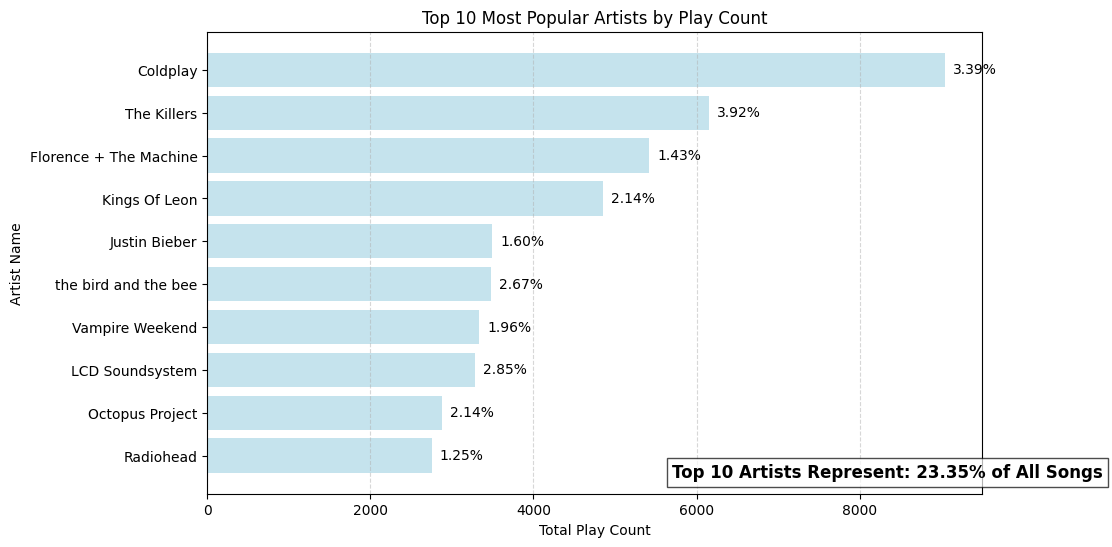

In [155]:
# Plot the top 10 artists
plt.figure(figsize=(10, 6))
bars = plt.barh(artist_popularity["artist_name"], artist_popularity["play_count"], color="lightblue", alpha=0.7)

plt.xlabel("Total Play Count")
plt.ylabel("Artist Name")
plt.title("Top 10 Most Popular Artists by Play Count")
plt.gca().invert_yaxis()  # Show highest count at the top
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Add text labels on bars
for bar, percentage in zip(bars, artist_popularity["song_percentage"]):
    plt.text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, f"{percentage:.2f}%", va="center")

# Add annotation for total percentage of top 10 artists
plt.text(plt.xlim()[1] * 0.6, len(artist_popularity) - 0.5,
         f"Top 10 Artists Represent: {top_10_total_percentage:.2f}% of All Songs",
         fontsize=12, fontweight="bold", bbox=dict(facecolor="white", alpha=0.7))


# Show the plot
plt.show()


#### Distribution of Song Play Counts
* Most songs have very few plays, with a sharp drop-off after 1-2 plays.
* A small number of songs are played repeatedly, indicating strong popularity bias.
* The extreme right-skew suggests that most songs are rarely engaged with, making it challenging for collaborative filtering to recommend less popular tracks.

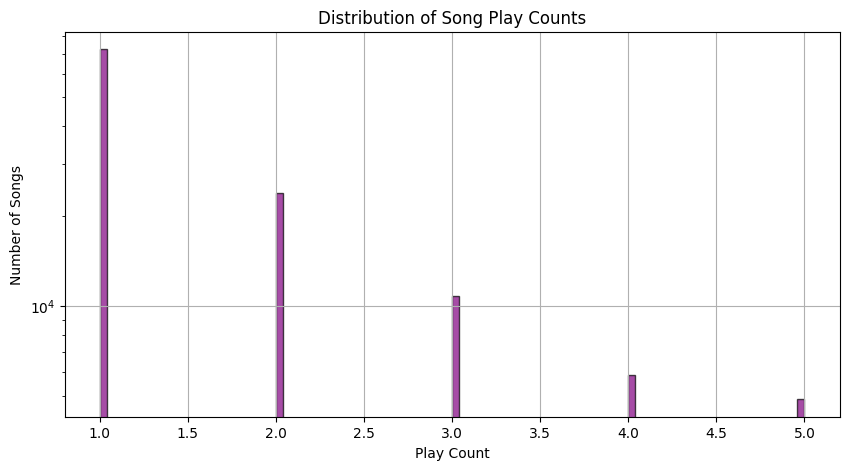

In [156]:
# Plot histogram of play counts
plt.figure(figsize=(10, 5))
plt.hist(df_final["play_count"], bins=100, color="purple", alpha=0.7, edgecolor="black")

plt.xlabel("Play Count")
plt.ylabel("Number of Songs")
plt.title("Distribution of Song Play Counts")
plt.yscale("log")  # Log scale for better visualization of long tail
plt.grid(True)

plt.show()

#### User-Song Interaction Sparsity
* The dataset exhibits extreme sparsity, meaning most songs are played by very few users.
* Many users have only a handful of interactions, making it challenging to generate personalized recommendations.
* Collaborative filtering models will work well for active users but struggle with cold-start users and niche songs.
* High interaction density in some areas suggests strong engagement with a core set of popular songs.

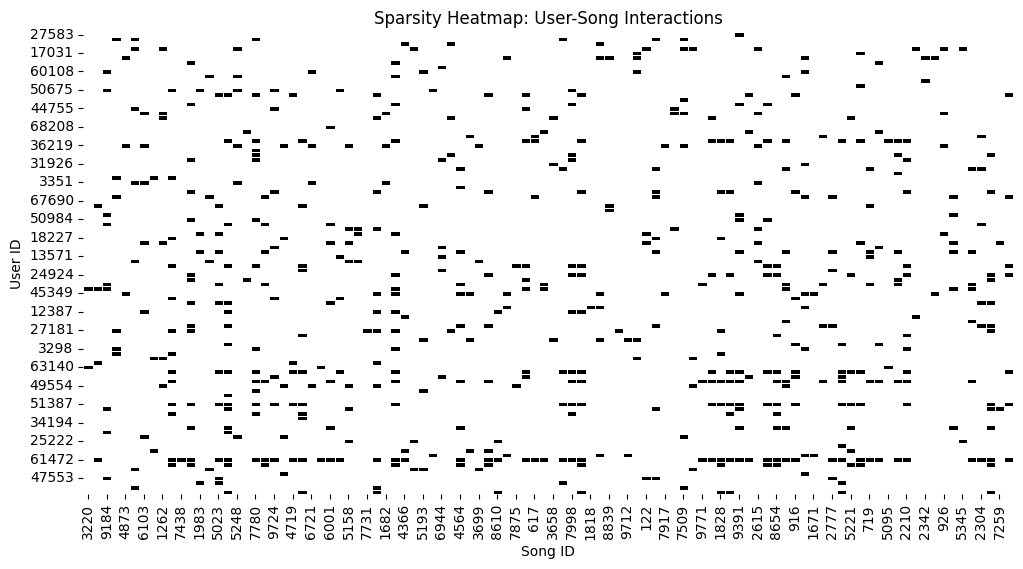

In [157]:
# Pivot to create a user-song interaction matrix (play counts)
interaction_matrix = df_final.pivot(index="user_id", columns="song_id", values="play_count")

# Convert to binary: 1 if user has interacted with song, NaN otherwise
binary_interaction = interaction_matrix.notna().astype(int)

# Sample a subset of users and songs if the dataset is too large
sample_users = np.random.choice(binary_interaction.index, size=100, replace=False)
sample_songs = np.random.choice(binary_interaction.columns, size=100, replace=False)

# Plot the heatmap (sampled for readability)
plt.figure(figsize=(12, 6))
sns.heatmap(binary_interaction.loc[sample_users, sample_songs], cmap="Greys", cbar=False, linewidths=0.5)
plt.xlabel("Song ID")
plt.ylabel("User ID")
plt.title("Sparsity Heatmap: User-Song Interactions")
plt.show()

#### Songs Released on Yearly Basis

* The Million Song Dataset shows a significant spike in song releases in **2007**, with **39,414 songs** recorded. The years leading up see steady increase. A quick drop is also observed after 2009.  
* This surge is likely not due to an actual explosion in music production, but rather advances in new technical data collection.




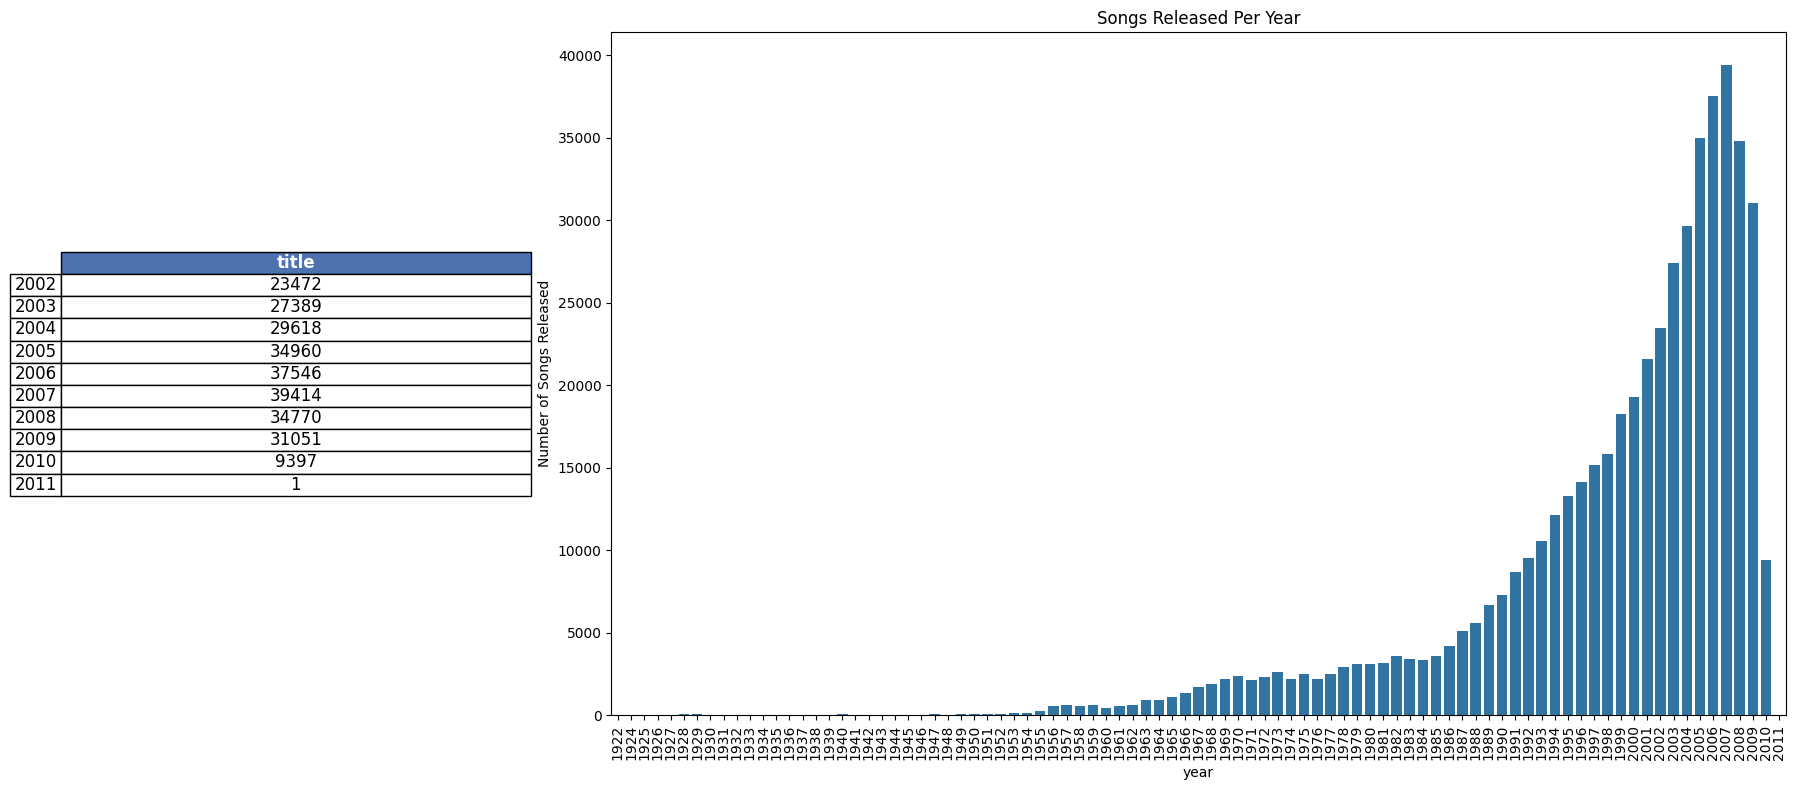

In [158]:
# Count the number of songs released in a year, use the songs_df
count_songs = song_df.groupby('year').count()['title']
count = pd.DataFrame(count_songs)
count.drop(count.index[0], inplace=True)

# Create a figure with a custom width ratio (25% table, 75% chart)
fig = plt.figure(figsize=(18, 8))  # Set overall figure size
gs = GridSpec(1, 2, width_ratios=[1, 3])  # Swap ratios: 1 (table) | 3 (chart)

# First subplot: Table (25% of the width)
ax1 = fig.add_subplot(gs[0])
ax1.axis("tight")
ax1.axis("off")

# Create the table with improved formatting
table = ax1.table(
    cellText=count.tail(10).values,  # Last 10 rows
    colLabels=count.columns,
    rowLabels=count.tail(10).index,
    cellLoc='center',
    loc='center'
)

# Format table (bold headers, background color, font size)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust table size

# Bold the headers
for key, cell in table._cells.items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4C72B0')  # Nice blue

# Second subplot: Bar plot (75% of the width)
ax2 = fig.add_subplot(gs[1])
sns.barplot(x=count.index, y='title', data=count, estimator=np.median, ax=ax2)
ax2.set_ylabel('Number of Songs Released')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title("Songs Released Per Year")

# Adjust layout
plt.tight_layout()
plt.show()

Now that we have explored the data, let's apply different algorithms to build recommendation systems.

## Building various models

### **Popularity-Based Recommendation Systems**

**Rank-Based Recommendation System Overview**
A rank-based system surfaces the most engaging songs based on objective listening patterns rather than collaborative filtering.Below are two key ranking approaches:
* Most Frequently Played Songs – Prioritizes total play count to highlight mainstream hits.
* Highest Average Play Count Per User – Identifies songs with high listener retention, revealing deeper engagement beyond mass popularity.

Top `n` Song popularity metrics (below) will be the foundation for this system.

In [159]:
# Calculate the average play_count per song_id
avg_play_count = df_final.groupby("song_id")["play_count"].mean().reset_index()
# Rename column for clarity
avg_play_count.rename(columns={"play_count": "avg_play_count"}, inplace=True)
# Calculate frequency of each song_id
song_play_frequency = df_final.groupby("song_id")["user_id"].count().reset_index()
# Rename column for clarity
song_play_frequency.rename(columns={"user_id": "play_frequency"}, inplace=True)

In [160]:
# Merge the two df together
song_stats = avg_play_count.merge(song_play_frequency, on="song_id")
display(song_stats.head())

,song_id,avg_play_count,play_frequency
0,21,1.622642,265
1,22,1.492424,132
2,52,1.729216,421
3,62,1.728070,114
4,93,1.452174,115


This ranked based recommendations can be leveraged with the below function.

In [161]:
# Build the function to find top n songs
def get_top_n_songs(df, n=10, metric="play_frequency"):
    """
    Returns the top n songs based on a given metric.

    Parameters:
    - df (DataFrame): The DataFrame containing song stats.
    - n (int): The number of top songs to return (default=10).
    - metric (str): The metric to rank songs by. Options:
        - "play_frequency" (default): Most played songs (number of unique user interactions).
        - "avg_play_count": Songs with the highest average play count per user.

    Returns:
    - DataFrame: Top `n` songs ranked by the specified metric.
    """

    if metric not in ["play_frequency", "avg_play_count"]:
        raise ValueError("Invalid metric. Choose 'play_frequency' or 'avg_play_count'.")

    # Sort by the chosen metric in descending order and return top n
    top_songs = df.sort_values(by=metric, ascending=False).head(n)

    return top_songs

**Rank Based in Action**
  * The system can retrieve top songs based on popularity, using either play frequency or average play count as ranking criteria:

In [162]:
 # Create a copy to avoid modifying df_final directly
df_final_copy = df_final.copy()
df_final_copy["song_id"] = df_final_copy["song_id"].astype(str)

# Ensure song_id is a string for merging in song_stats
song_stats["song_id"] = song_stats["song_id"].astype(str)

# Deduplicate df_final_copy by song_id (keep only one row per song)
df_dedup = df_final_copy[df_columns].drop_duplicates(subset=["song_id"])

# Get top 10 most frequently played songs
display(Markdown("### Top 10 Most Frequently Played Songs"))
top_10_frequent = get_top_n_songs(song_stats, n=10, metric="play_frequency")

# Merge with metadata before displaying
top_10_frequent = top_10_frequent.merge(df_dedup, on="song_id", how="left")
display(top_10_frequent[df_columns + ["play_frequency"]])

# Add a visual separator
display(Markdown("---"))

# Get top 10 songs with highest average play count
display(Markdown("### Top 10 Songs with Highest Average Play Count"))
top_10_avg_play = get_top_n_songs(song_stats, n=10, metric="avg_play_count")

# Merge with metadata before displaying
top_10_avg_play = top_10_avg_play.merge(df_dedup, on="song_id", how="left")
display(top_10_avg_play[df_columns + ["avg_play_count"]])


### Top 10 Most Frequently Played Songs

,song_id,user_id,play_count,title,artist_name,release,year,implicit_score,play_frequency
0,8582,56576,3,Use Somebody,Kings Of Leon,Use Somebody,2008,2,751
1,352,56576,4,Dog Days Are Over (Radio Edit),Florence + The Machine,Now That's What I Call Music! 75,0,2,748
2,2220,56576,2,Sehr kosmisch,Harmonia,Musik von Harmonia,0,2,713
3,1118,27018,2,Clocks,Coldplay,A Rush Of Blood To The Head,2002,2,662
4,4152,27018,2,The Scientist,Coldplay,The Scientist,2002,2,652
5,5531,57932,3,Secrets,OneRepublic,Waking Up,2009,2,618
6,4448,56576,2,Fireflies,Charttraxx Karaoke,Karaoke Monthly Vol. 2 (January 2010),2009,2,609
7,6189,56576,1,Creep (Explicit),Radiohead,Pablo Honey,1993,1,606
8,6293,27018,2,Yellow,Coldplay,Yellow,2000,2,583
9,1334,35457,1,Hey_ Soul Sister,Train,Save Me_ San Francisco,0,1,570


---

### Top 10 Songs with Highest Average Play Count

,song_id,user_id,play_count,title,artist_name,release,year,implicit_score,avg_play_count
0,7224,23297,5,Victoria (LP Version),Old 97's,Hit By A Train: The Best Of Old 97's,2006,3,3.373832
1,8324,23297,5,The Big Gundown,The Prodigy,Invaders Must Die Remixes and Bonus Tracks,2009,3,2.625000
2,6450,23297,5,Brave The Elements,Colossal,Brave The Elements - EP,0,3,2.578431
3,9942,34225,5,Greece 2000,Three Drives,Greece 2000,1997,3,2.486667
4,5531,57932,3,Secrets,OneRepublic,Waking Up,2009,2,2.309061
5,5653,57932,1,Transparency,White Denim,Workout Holiday,2008,1,2.296296
6,8483,59579,3,Video Killed The Radio Star,The Buggles,Friends Reunited: Music Of The Year 1979,1979,2,2.235772
7,2220,56576,2,Sehr kosmisch,Harmonia,Musik von Harmonia,0,2,2.220196
8,657,7320,1,Luvstruck,Southside Spinners,Hard House Anthems,1999,1,2.218543
9,614,37938,1,You're The One,Dwight Yoakam,If There Was A Way,1990,1,2.217158


### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE, and F1_Score@k to evaluate the model performance.

Below we are loading the **dataset**, which is a **pandas dataframe**, into a **different format called `surprise.dataset.DatasetAutoFolds`** which is required by this library. To do this we will be **using the classes `Reader` and `Dataset`**

You will also notice here that we read the dataset by providing a scale of ratings. However, as you would know, we do not have ratings data of the songs. In this case, we are going to use play_count as a proxy for ratings with the assumption that the more the user listens to a song, the higher the chance that they like the song

In [163]:
# Check the mean to decide threshold
global_mean = df_final["play_count"].mean()
print(f"Global Mean Play Count: {global_mean:.4f}")

Global Mean Play Count: 1.7001


#### Model Evaluations and Comparisions

In [164]:
DEFAULT_K = 30
# Threshold. of 1.8, slightly above the mean
DEFAULT_THRESHOLD = 1.8

# Dictionary to store model evaluation results incrementally
model_comparison_results = {}

def precision_recall_at_k(model, model_name, testset, k=DEFAULT_K, threshold=DEFAULT_THRESHOLD):
    """
    Evaluates a recommendation model and stores results **without any output**.

    Parameters:
    - model (Surprise Model): The trained model to evaluate.
    - model_name (str): Name of the model for storage & reference.
    - k (int): Number of recommendations to consider.
    - threshold (float): Minimum rating considered as "relevant."

    Returns:
    - Dictionary of model evaluation results (RMSE, Precision@K, Recall@K, F1-score).

    Updates:
    - Stores results in `model_comparison_results` to avoid redundant computation.
    """

    # Skip evaluation if already stored
    if model_name in model_comparison_results:
        return model_comparison_results[model_name]

    # Generate evaluation predictions
    predictions = model.test(testset)
    rmse_value = accuracy.rmse(predictions, verbose=False)  # No print output

    # Map evaluation predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Compute precision and recall
        n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
        n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
        n_rel_and_rec_k = sum((true_r >= threshold and est >= threshold) for est, true_r in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Compute averages
    precision_avg = round(sum(precisions.values()) / len(precisions), 3)
    recall_avg = round(sum(recalls.values()) / len(recalls), 3)
    f1_score = round((2 * precision_avg * recall_avg) / (precision_avg + recall_avg), 3) if (precision_avg + recall_avg) > 0 else 0

    # Store results
    model_comparison_results[model_name] = {
        "RMSE": rmse_value,
        "Precision@k": precision_avg,
        "Recall@k": recall_avg,
        "F1-score": f1_score
    }

    return model_comparison_results[model_name]

Utility to display model comparisions table:

In [165]:
def pretty_print_model_evaluations(model_comparison_results):
    """
    Display model evaluation results as a table.

    Parameters:
    - model_comparison_results (dict): Dictionary storing RMSE, Precision@K, Recall@K, and F1-score.
    """
    model_evaluations_df = pd.DataFrame.from_dict(model_comparison_results, orient='index')
    model_evaluations_df = model_evaluations_df.reset_index().rename(columns={'index': 'Model'})

    # Display as a clear table
    display(model_evaluations_df)

Utility to display model comparisions plot:

In [166]:
def plot_model_comparison_bars_grid(model_comparison_results):
    """
    Plots evaluation metrics (RMSE, Precision@K, Recall@K, F1-score) in a horizontal grid layout,
    with different colored bars representing each model.

    Parameters:
    - model_comparison_results (dict): Dictionary containing model names as keys and evaluation results as values.
    """
    metrics = ["RMSE", "Precision@k", "Recall@k", "F1-score"]
    num_metrics = len(metrics)

    # Set up a grid layout (1 row, multiple columns) for better visualization
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))

    model_names = list(model_comparison_results.keys())
    colors = plt.cm.get_cmap("tab10", len(model_names))  # Get distinct colors for models

    for i, metric in enumerate(metrics):
        ax = axes[i]
        values = [model_comparison_results[model][metric] for model in model_names]

        ax.bar(model_names, values, color=[colors(j) for j in range(len(model_names))])
        ax.set_title(metric)
        ax.set_ylabel(metric)
        ax.set_xticklabels(model_names, rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

#### Prepare Data for Collaborative Filtering Models

In [167]:
# Define global constants
SAMPLE_USER_ONE = 6958
SAMPLE_USER_ONE_SONG_HEARD = 1671
SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT = df_final[(df_final["user_id"] == SAMPLE_USER_ONE) &
                             (df_final["song_id"] == SAMPLE_USER_ONE_SONG_HEARD)]["play_count"].values[0]
assert SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT == 2  # Actual play count

SAMPLE_USER_ONE_SONG_UNHEARD = 3232
SAMPLE_USER_TWO = 47786
SAMPLE_USER_TWO_SONG_UNHEARD = 2048

# User two was randonly chosen from th last user in the dataset
assert SAMPLE_USER_TWO == df_final["user_id"].iloc[-1]
sample_user_two_songs = df_final[df_final["user_id"] == SAMPLE_USER_TWO]["song_id"].unique()
# User two's unheard song was the first unheard song found
assert SAMPLE_USER_TWO_SONG_UNHEARD == list(set(df_final["song_id"].unique()) - set(sample_user_two_songs))[0]

In [168]:
# Define the expected rating scale
reader = Reader(rating_scale=(0, 5))

# Selecting required columns
df_surprise = df_final[["user_id", "song_id", "play_count"]]

# Load the data into Surprise format
data = Dataset.load_from_df(df_surprise, reader)

# Convert raw ratings to list for manual control
raw_ratings = list(data.raw_ratings)

# Separate ratings for the two target users
ratings_user_one = [r for r in raw_ratings if r[0] == SAMPLE_USER_ONE]  # Force User 6958 into trainset
ratings_user_two = [r for r in raw_ratings if r[0] == SAMPLE_USER_TWO]  # Force User 47786 into trainset

# Remaining ratings (excluding the two forced users)
remaining_ratings = [r for r in raw_ratings if r[0] not in {SAMPLE_USER_ONE, SAMPLE_USER_TWO}]

# Shuffle remaining ratings for random train-test distribution
random.shuffle(remaining_ratings)

# Define train-test split ratio (60% train, 40% test)
split_idx = int(len(remaining_ratings) * 0.6)

# Create trainset: Include both users explicitly
trainset_raw = ratings_user_one + ratings_user_two + remaining_ratings[:split_idx]

# Create testset: Use all songs not in the trainset for test users
testset_raw = remaining_ratings[split_idx:]

# Construct Surprise train and test sets
trainset = data.construct_trainset(trainset_raw)
testset = data.construct_testset(testset_raw)  # Test set must remain in raw format

# Verification
train_users = {trainset.to_raw_uid(uid) for uid in trainset.all_users()}

assert SAMPLE_USER_ONE in train_users, f"User {SAMPLE_USER_ONE} is not in trainset!"
assert SAMPLE_USER_TWO in train_users, f"User {SAMPLE_USER_TWO} is not in trainset!"

print(f"User {SAMPLE_USER_ONE} and {SAMPLE_USER_TWO} are in the trainset.")

User 6958 and 47786 are in the trainset.


#### Define Sample Users and Song Interactions for Testing

#### Evaluating Model Predictions for Sample Users

In [169]:
# Dictionary to store predictions
predictions_store = defaultdict(list)

def make_and_store_prediction(model, model_name, user_id, song_id, actual_play_count=None):
    """
    Predicts the play count for a given user and song using the provided model.
    Stores the prediction in a table format, including actual play count if available.
    Also computes and stores prediction error when actual play count is provided.
    """
    pred = model.predict(uid=user_id, iid=song_id, r_ui=actual_play_count)

    # Compute absolute error if actual play count is available
    prediction_error = abs(pred.est - actual_play_count) if actual_play_count is not None else "N/A"

    entry = {
        'Model': model_name,
        'Song ID': song_id,
        'Predicted Play Count': round(pred.est, 2),
        'Actual Play Count': actual_play_count if actual_play_count is not None else "N/A",
        'Prediction Error': round(prediction_error, 2) if prediction_error != "N/A" else "N/A"
    }
    predictions_store[user_id].append(entry)

def print_predictions_for_user(user_id):
    """
    Prints all stored predictions for a given user in a formatted table.
    """
    if user_id in predictions_store:
        df = pd.DataFrame(predictions_store[user_id])
        print(f"\nPredictions for User {user_id}:")
        print(df.to_string(index=False))
    else:
        print(f"No predictions found for User {user_id}.")

### **User User Similarity-Based Collaborative Filtering**

For user-based collaborative filtering, the focus is on measuring similarity between users based on their shared song interactions.

To build the user-user-similarity-based and subsequent models we will use the "surprise" library.

#### Train User-User Baseline

* Precision@k (0.62) and Recall@k (0.45) suggest this model provides somewhat relevant recommendations but lacks strong recall.
* RMSE is relatively high (0.87), indicating that the predicted play counts are not very close to actual values.
* The F1-score (0.52) suggests a reasonable trade-off between relevance and exploration.




In [170]:
# === Build the User-User Similarity Model ===
model_name = "user-user-baseline"

# Define similarity options
sim_options = {
    "name": "cosine",  # Similarity measure: Cosine, Pearson, or MSD
    "user_based": True,  # User-User similarity
}

# Baseline estimate options (ALS method for bias adjustment)
bsl_options = {
    "method": "als",
    "n_epochs": 10,
    "reg_u": 12,  # Regularization for users
    "reg_i": 5,  # Regularization for items
}

# Instantiate the model with similarity & baseline options
user_user_baseline_model = KNNBaseline(k=40, sim_options=sim_options, bsl_options=bsl_options)

# Train the model on the trainset
user_user_baseline_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()

# Compute Precision@K, Recall@K, and F1 Score
precision_recall_at_k(model=user_user_baseline_model, model_name=model_name, testset=testset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'RMSE': 0.8672866429596706,
 'Precision@k': 0.611,
 'Recall@k': 0.454,
 'F1-score': 0.521}

#### Predict and Store Play Counts for Sample Users

In [171]:
# Storing prediction for a song the user has heard (actual play count = 2)
make_and_store_prediction(
    user_user_baseline_model,
    'user-user-baseline',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    actual_play_count=SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
make_and_store_prediction(
    user_user_baseline_model,
    'user-user-baseline',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
# Predicting play_count for a sample user with a song not-listened by the user
make_and_store_prediction(
    user_user_baseline_model,
    'user-user-baseline',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD,
)

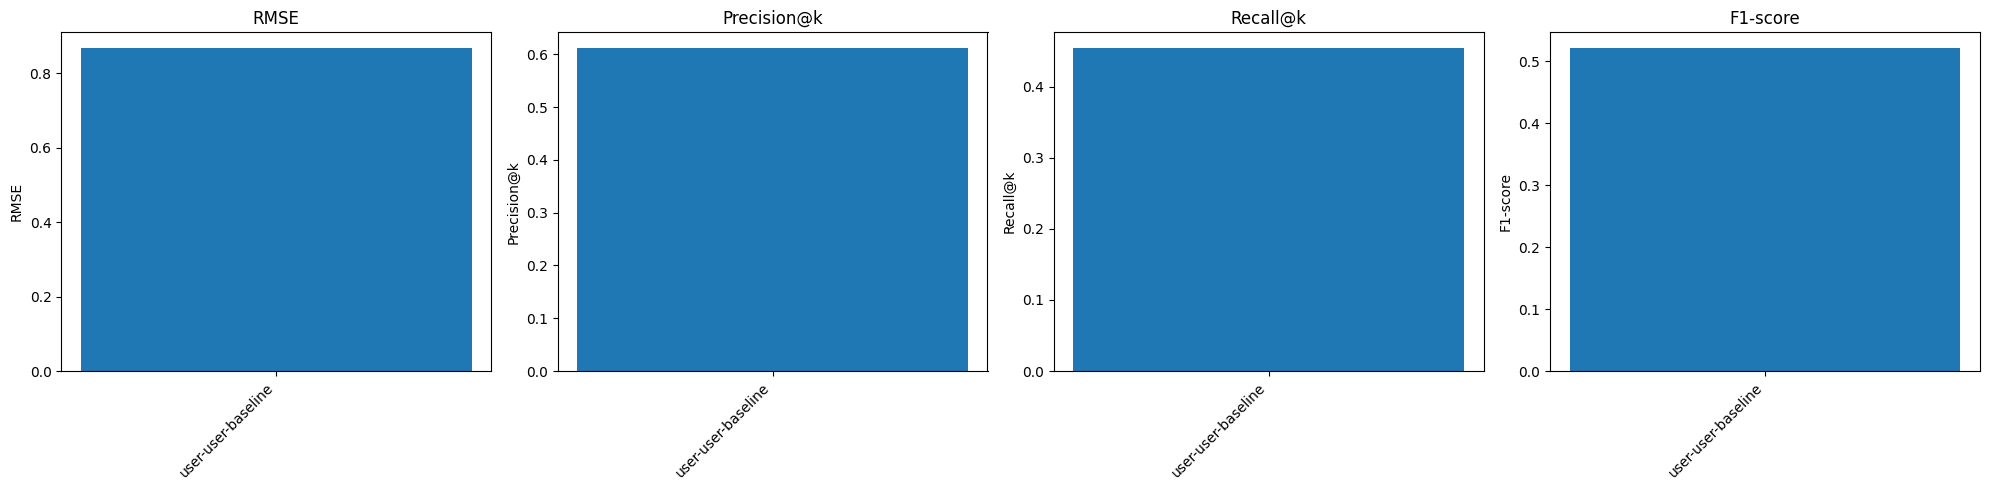

In [172]:
plot_model_comparison_bars_grid(model_comparison_results)

Now, let's try to tune the model and see if we can improve the model performance.

* Cosine Similarity → Measures how similar two users are based on the angle between their interaction vectors.
* Pearson Correlation → Accounts for differences in user preferences by normalizing ratings.
* Mean Squared Difference (MSD) → Penalizes large rating differences, making it useful for detecting users with consistent behavior.
* Why not include "pearson_baseline"? Since user-user models suffer from sparsity issues, traditional Pearson correlation works better without additional bias adjustments, which are more beneficial in item-based filtering.

In [173]:
# Define the parameter grid for tuning
param_grid = {
    "k": [10, 20, 30, 40],  # Number of neighbors
    "sim_options": {
        "name": ["cosine", "pearson", "msd"],  # Similarity metrics
        "user_based": [True],  # User-user collaborative filtering
    }
}

# Initialize GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(KNNBaseline, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

# Fit the grid search model using the entire dataset
grid_search.fit(data)

# Retrieve the best RMSE score
best_rmse = grid_search.best_score["rmse"]
print(f"Best RMSE Score: {best_rmse:.4f}")

# Retrieve the best parameter combination
best_params = grid_search.best_params["rmse"]
print("Best Parameters:", best_params)

Best RMSE Score: 1.0223
Best Parameters: {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}}


In [174]:
model_name = "user-user-hypertuned"

# Retrieve the best parameters from GridSearch
best_k = best_params["k"]
best_sim_options = best_params["sim_options"]

# Initialize the optimized model
user_to_user_hypertuned_model = KNNBaseline(k=best_k, sim_options=best_sim_options)

# Train the model on the trainset
user_to_user_hypertuned_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute precision@k, recall@k, and F1 score, store the results
precision_recall_at_k(model=user_to_user_hypertuned_model, model_name=model_name, testset=testset, k=best_k)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'RMSE': 0.5377468953992787,
 'Precision@k': 0.843,
 'Recall@k': 0.538,
 'F1-score': 0.657}

#### User-User Hypertuning Made Improvements
* Precision@k increased from 0.62 → 0.84
* Recall@k from 0.45 → 0.53
* F1-score from 0.52 → 0.65, indicating more relevant and diverse recommendations.
* Drastically lower RMSE (0.53 vs. 0.87)
* Predictions are now much closer to actual play counts, showing better overall accuracy.
* **Clear outperformer** - The hypertuned model surpasses the baseline in all metrics, making it a better choice for both accuracy and ranking quality.

#### Re-predict (and Store) Play Counts for Sample Users

In [175]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
make_and_store_prediction(
    user_to_user_hypertuned_model,
    'user-user-hypertuned',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    actual_play_count=SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
make_and_store_prediction(
    user_to_user_hypertuned_model,
    'user-user-hypertuned',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
make_and_store_prediction(
    user_to_user_hypertuned_model,
    'user-user-hypertuned',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

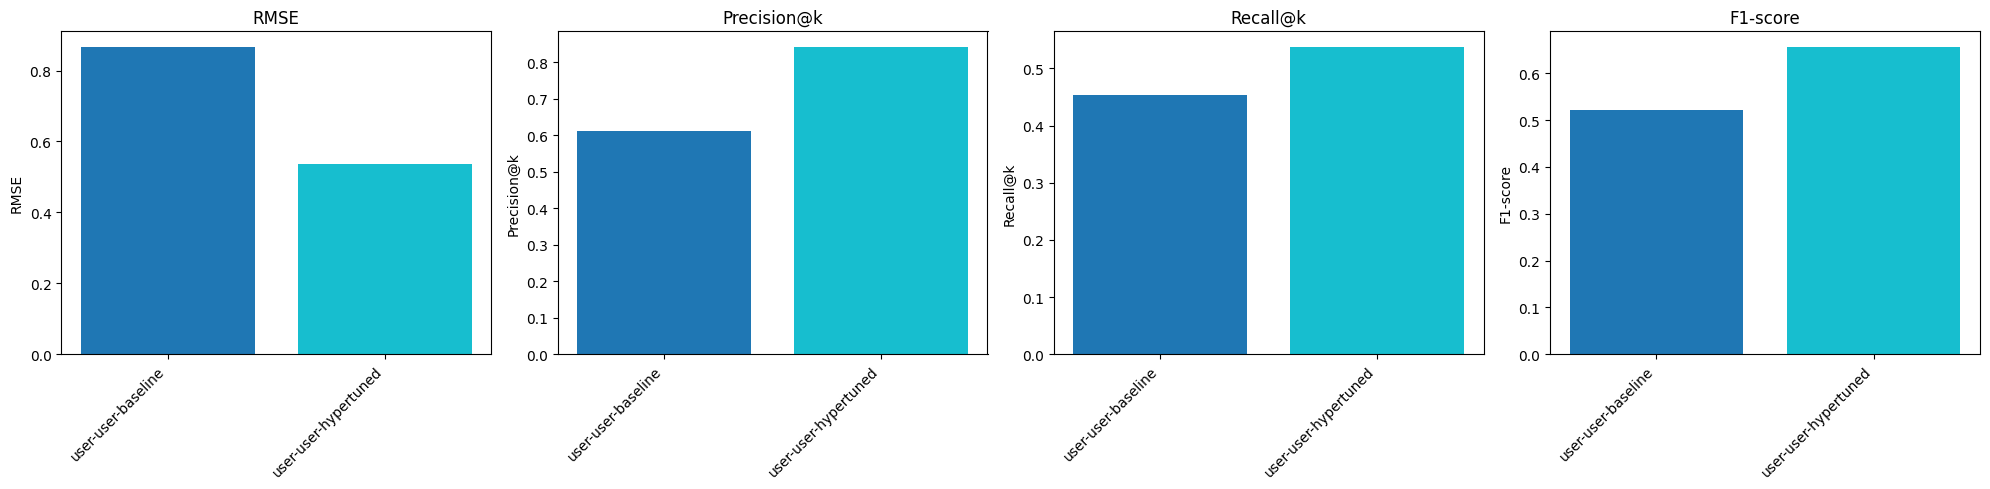

In [176]:
plot_model_comparison_bars_grid(model_comparison_results)

**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?

### Find Similar Songs Using Best User-User CF
* Based on user listening patterns, the hypertuned model identifies five nearest-neighbor songs similar to the reference track (Inner ID 0).
* The results include a mix of rock, alternative, and hip-hop, showing how collaborative filtering groups songs based on shared user preferences rather than genre alone.

In [177]:
def get_similar_songs_metadata(model, trainset, df_final, df_columns, inner_id=0, k=5):
    """
    Retrieves metadata for the top K nearest neighbors of a given song based on a trained model.

    Parameters:
    - model: Trained recommendation model (User-User, Item-Item, etc.).
    - trainset: Surprise trainset object used for ID conversion.
    - df_final: DataFrame containing song metadata.
    - df_columns: List of columns to keep from df_final.
    - inner_id (int): Inner ID of the reference song.
    - k (int): Number of nearest neighbors to retrieve.

    Returns:
    - DataFrame containing metadata for similar songs.
    """

    # Step 1: Get nearest neighbors
    similar_songs_inner = model.get_neighbors(inner_id, k=k)

    # Step 2: Convert inner IDs to raw song IDs
    similar_songs_actual = []
    for inner_id in similar_songs_inner:
        try:
            raw_iid = trainset.to_raw_iid(inner_id)
            similar_songs_actual.append(str(raw_iid))  # Ensure string format
        except ValueError:
            print(f"Warning: Inner ID {inner_id} not found in trainset!")
            continue

    # Step 3: Ensure song_id is treated as string for merging
    df_final["song_id"] = df_final["song_id"].astype(str)

    # Step 4: Retrieve metadata
    similar_songs_metadata = df_final[df_final["song_id"].isin(similar_songs_actual)][df_columns].drop_duplicates()

    return similar_songs_metadata


In [178]:
user_user_similar_songs_metadata = get_similar_songs_metadata(
    model=user_to_user_hypertuned_model,
    trainset=trainset,
    df_final=df_final,
    df_columns=df_columns,
    inner_id=0,  # Reference song
    k=5  # Get 5 nearest songs
)

display(user_user_similar_songs_metadata.head())

,song_id,user_id,play_count,title,artist_name,release,year,implicit_score
203,549,6958,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007,1
209,1050,6958,5,Wet Blanket,Metric,Old World Underground_ Where Are You Now?,2003,3
221,2107,6958,1,Stadium Love,Metric,Fantasies,2009,1
226,2304,6958,1,Daddy's Eyes,The Killers,Sawdust,2006,1
228,2501,6958,1,Camaro,Kings Of Leon,Because Of The Times,2007,1


#### Generating Personalized Song Recommendations

Below we will be implementing a function where the input parameters are:

- df: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- model: The algorithm we want to use **for predicting the play_count**
- **trainset**
- top_n: The **number of songs we want to recommend**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [179]:
# Reusable function for generating recommendations
def get_recommendations(df, user_id, model, trainset, top_n=5):
    """
    Generates top_n song recommendations for a given user using a specified recommendation model.

    Parameters:
    - df (DataFrame): Dataset containing song metadata (song_id, title, artist_name, release).
    - user_id (int/str): The user ID for whom recommendations are generated.
    - model: The trained recommendation model (Co-Clustering, SVD, User-User, Item-Item, etc.).
    - trainset: Surprise trainset object for checking user-song interactions.
    - top_n (int): Number of recommendations to return.

    Returns:
    - DataFrame with top_n recommended songs and estimated play counts.
    """

    try:
        inner_user_id = trainset.to_inner_uid(user_id)
    except ValueError:
        print(f"Warning: User ID {user_id} not found in trainset!")
        return pd.DataFrame()

    # Get all songs the user has interacted with
    heard_songs = set(df[df["user_id"] == user_id]["song_id"].unique())

    # Get all unique song IDs in dataset
    all_song_ids = set(df["song_id"].unique())

    # Find songs the user has NOT played
    unseen_songs = list(all_song_ids - heard_songs)

    print(f"User {user_id} (Internal ID: {inner_user_id}) - Heard: {len(heard_songs)}, Unseen: {len(unseen_songs)}")

    if not unseen_songs:
        print(f"No unseen songs for User {user_id}, returning empty recommendations.")
        return pd.DataFrame()

    # Predict play count for all unseen songs
    predictions = []
    for song_id in unseen_songs:
        try:
            pred = model.predict(inner_user_id, song_id)
            predictions.append(pred)
        except Exception as e:
            print(f"Error predicting for Song ID {song_id}: {e}")

    if not predictions:
        print(f"No predictions generated for User {user_id}.")
        return pd.DataFrame()

    # Sort predictions by estimated play count (descending order) and select top N
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n]

    # Extract song IDs from top predictions
    top_song_ids = [pred.iid for pred in top_predictions]

    # Retrieve song details from the original dataframe, ensuring uniqueness
    top_songs = df[df["song_id"].isin(top_song_ids)].drop_duplicates(subset=["song_id"])

    # Merge with predictions to include estimated play counts
    top_songs = top_songs.merge(
        pd.DataFrame([(pred.iid, pred.est) for pred in top_predictions], columns=["song_id", "predicted_play_count"]),
        on="song_id",
        how="left"
    )

    return top_songs

In [180]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine
sample_user_one_best_user_user_recommendations = get_recommendations(df=df_final, trainset=trainset, user_id=SAMPLE_USER_ONE, model=user_to_user_hypertuned_model, top_n=15)
display(sample_user_one_best_user_user_recommendations)

User 6958 (Internal ID: 0) - Heard: 39, Unseen: 524


,user_id,song_id,play_count,title,release,artist_name,year,implicit_score,predicted_play_count
0,27018,1682,3,Tuxedo Hat,One Ten Hundred Thousand Million,Octopus Project,2005,2,1.699466
1,27018,4724,5,Tortured Soul,Skream!,Skream,2006,3,1.699466
2,27018,6964,1,Is This It,Is This It,The Strokes,2001,1,1.699466
3,27018,7878,2,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466
4,56576,1286,5,Somebody To Love,My Worlds,Justin Bieber,2010,3,1.699466
5,49549,52,3,Halo,Halo,Beyoncé,2008,2,1.699466
6,49549,1691,3,Hips Don't Lie (featuring Wyclef Jean),Essential R&B Hit Selection,Shakira Featuring Wyclef Jean,0,2,1.699466
7,49549,7998,3,Nothin' On You [feat. Bruno Mars] (Album Version),Nothin' On You [feat. Bruno Mars],B.o.B,0,2,1.699466
8,49549,8698,3,Whatcha Say,Whatcha Say,Jason Derulo,2009,2,1.699466
9,44689,5823,1,We Are The Sleepyheads,The Life Pursuit,Belle & Sebastian,2006,1,1.699466


#### Refining and Ranking Song Recommendations
* Corrects the play_counts and ranking the above songs.
* Subtracting 1/np.sqrt(n) stabilizes recommendations by down-weighting less reliable predictions, leading to more balanced rankings.

In [181]:
def ranking_songs(recommendations, playing_count):
    """
    Adjusts and ranks recommended songs based on corrected play counts.

    Parameters:
    - recommendations: DataFrame with 'song_id' and 'predicted_play_count'.
    - playing_count: DataFrame with 'song_id' and 'play_count' (actual play count).

    Returns:
    - DataFrame with ranked songs and corrected play counts.
    """

    # Ensure both song_id columns are of type string for reliable merging
    recommendations["song_id"] = recommendations["song_id"].astype(str)
    playing_count["song_id"] = playing_count["song_id"].astype(str)

    # Rename existing play_count in recommendations to avoid conflicts
    recommendations = recommendations.rename(columns={"play_count": "existing_play_count"})

    # Merge actual play counts with recommendations
    ranked_songs = recommendations.merge(playing_count, on="song_id", how="left")

    # Ensure 'play_count' exists, otherwise print warning
    if "play_count" not in ranked_songs.columns:
        print("Warning: 'play_count' column is missing after merge!")

    # Replace missing play counts with 1 (for unseen songs)
    ranked_songs["play_count"] = ranked_songs["play_count"].fillna(1)

    # Apply correction: predicted_play_count - (1 / sqrt(play_count))
    ranked_songs["corrected_play_count"] = (
        ranked_songs["predicted_play_count"] - (1 / np.sqrt(ranked_songs["play_count"]))
    )

    # Drop unnecessary columns for cleaner display
    ranked_songs = ranked_songs.drop(columns=["existing_play_count"], errors="ignore")

    # Rank songs based on corrected play counts (higher is better)
    ranked_songs = ranked_songs.sort_values(by="corrected_play_count", ascending=False).reset_index(drop=True)

    return ranked_songs


#### Aggregating Play Counts for Recommended Songs

In [182]:
def get_play_counts(df_final, recommendations_df, agg_method="max"):
    """
    Retrieve and aggregate play counts for recommended songs.

    Parameters:
    - df_final (pd.DataFrame): DataFrame containing song play counts.
    - recommendations_df (pd.DataFrame): DataFrame containing song recommendations.
    - agg_method (str): Aggregation method for play counts ('max', 'mean', 'median').

    Returns:
    - pd.DataFrame: DataFrame with unique song_id and aggregated play_count.
    """

    # **Early Exit: If recommendations_df is empty, return an empty DataFrame**
    if recommendations_df.empty:
        print("Warning: No recommendations provided!")
        return pd.DataFrame(columns=["song_id", "play_count"])

    # **Make copies to prevent modifying original DataFrames**
    df_final_copy = df_final.copy()
    recommendations_df_copy = recommendations_df.copy()

    # **Convert song_id to string only if necessary**
    if pd.to_numeric(df_final_copy["song_id"], errors="coerce").notna().any():
        df_final_copy["song_id"] = df_final_copy["song_id"].astype(str)
    if pd.to_numeric(recommendations_df_copy["song_id"], errors="coerce").notna().any():
        recommendations_df_copy["song_id"] = recommendations_df_copy["song_id"].astype(str)

    # **Validate that 'play_count' exists in df_final**
    if "play_count" not in df_final_copy.columns:
        raise KeyError("Error: 'play_count' column is missing in df_final!")

    # **Find missing song_ids in df_final**
    missing_songs = set(recommendations_df_copy["song_id"]) - set(df_final_copy["song_id"])
    if missing_songs:
        print(f"Warning: {len(missing_songs)} song_id(s) in recommendations are missing from df_final!")

    # **Filter df_final to only include recommended song IDs**
    filtered_df = df_final_copy[df_final_copy["song_id"].isin(recommendations_df_copy["song_id"])]

    # **Early Exit: If no matching rows found, return an empty DataFrame**
    if filtered_df.empty:
        print("Warning: No matching songs found in df_final!")
        return pd.DataFrame(columns=["song_id", "play_count"])

    # **Ensure play_count has no NaN values before aggregation**
    filtered_df = filtered_df.dropna(subset=["play_count"])

    # **Aggregate play_count using the specified method**
    if agg_method == "max":
        playing_count_df = filtered_df.groupby("song_id", as_index=False)["play_count"].max()
    elif agg_method == "mean":
        playing_count_df = filtered_df.groupby("song_id", as_index=False)["play_count"].mean()
    elif agg_method == "median":
        playing_count_df = filtered_df.groupby("song_id", as_index=False)["play_count"].median()
    else:
        raise ValueError("Error: Invalid agg_method. Choose 'max', 'mean', or 'median'.")

    return playing_count_df

**User-Based Recommendations**
- Predictions cluster around the global mean (~1.7) and indicate the model is not strongly personalizing recommendations and suggests the system relies more on overall dataset trends than user-song affinities.
- **After incorporating the implicit score feature**, predictions now vary per user, allowing the model to distinguish individual listening patterns and tailor recommendations accordingly.  




In [183]:
# Retrieve play counts for U-U recommendations
user_playing_count_df = get_play_counts(df_final, sample_user_one_best_user_user_recommendations, agg_method="max")

# Apply ranking function
user_one_corrected_ranked_recommendations = ranking_songs(sample_user_one_best_user_user_recommendations, user_playing_count_df)
display(user_one_corrected_ranked_recommendations.head())

,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,27018,1682,Tuxedo Hat,One Ten Hundred Thousand Million,Octopus Project,2005,2,1.699466,5,1.252252
1,27018,4724,Tortured Soul,Skream!,Skream,2006,3,1.699466,5,1.252252
2,27018,6964,Is This It,Is This It,The Strokes,2001,1,1.699466,5,1.252252
3,27018,7878,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466,5,1.252252
4,56576,1286,Somebody To Love,My Worlds,Justin Bieber,2010,3,1.699466,5,1.252252


In [184]:
# make a list for most active user
most_active = 61472
sample_user_most_active_best_user_user_recommendations = get_recommendations(
    df=df_final,
    user_id=most_active,
    model=user_to_user_hypertuned_model,
    trainset=trainset,
    top_n=15
)
most_active_playing_count_df = get_play_counts(df_final, sample_user_most_active_best_user_user_recommendations, agg_method="max")

# Apply ranking function
most_active_cf_ranked_recommendations = ranking_songs(sample_user_most_active_best_user_user_recommendations, most_active_playing_count_df)
display(most_active_cf_ranked_recommendations.head())

User 61472 (Internal ID: 313) - Heard: 243, Unseen: 320


,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,6958,1818,Teenager,Modapop,Camera Obscura,0,1,1.699466,5,1.252252
1,6958,5340,Postcards From Italy,The Gulag Orkestar,Beirut,2005,1,1.699466,5,1.252252
2,27018,1682,Tuxedo Hat,One Ten Hundred Thousand Million,Octopus Project,2005,2,1.699466,5,1.252252
3,27018,4724,Tortured Soul,Skream!,Skream,2006,3,1.699466,5,1.252252
4,27018,6618,Meteor,Ray Guns Are Not Just The Future,the bird and the bee,2009,1,1.699466,5,1.252252


### Item Item Similarity-based collaborative filtering recommendation systems

For item-based filtering, the goal is to find songs that are similar based on **user interactions** rather than user similarity.

#### Train Item Item Baseline

In [185]:
model_name = "item-item-baseline"

# Define similarity options for Item-Item CF
sim_options = {
    "name": "cosine",  # Using cosine similarity
    "user_based": False  # Switch to Item-Item CF
}

# Initialize the Item-Item collaborative filtering model
item_item_baseline_model = KNNBaseline(k=40, sim_options=sim_options)

# Train the model on the trainset
item_item_baseline_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute Precision@30, Recall@30, and F1 Score
precision_recall_at_k(model=item_item_baseline_model, model_name=model_name, testset=testset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'RMSE': 0.9098791272077277,
 'Precision@k': 0.449,
 'Recall@k': 0.417,
 'F1-score': 0.432}

**Item-Item Baseline struggles across all metrics, making it a weaker choice for recommendations**:
* Precision@k (0.45) and Recall@k (0.41) are significantly lower than both User-User Baseline (0.62/0.45) and User-User Hypertuned (0.83/0.54), indicating weaker recommendation relevance.
* The Item-Item Baseline model has the worst prediction accuracy so far (0.910). Its estimated play counts are further from actual values compared to both User-User models.



In [186]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) listened to by the user
make_and_store_prediction(
    item_item_baseline_model,
    'item_item_baseline',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    actual_play_count=SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
# Predicting play count for a sample user_id 6958 and song unheard
make_and_store_prediction(
    item_item_baseline_model,
    'item_item_baseline',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
# # Predict the play count for a user that has not listened to the song (with song_id 1671)
make_and_store_prediction(
    item_item_baseline_model,
    'item_item_baseline',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

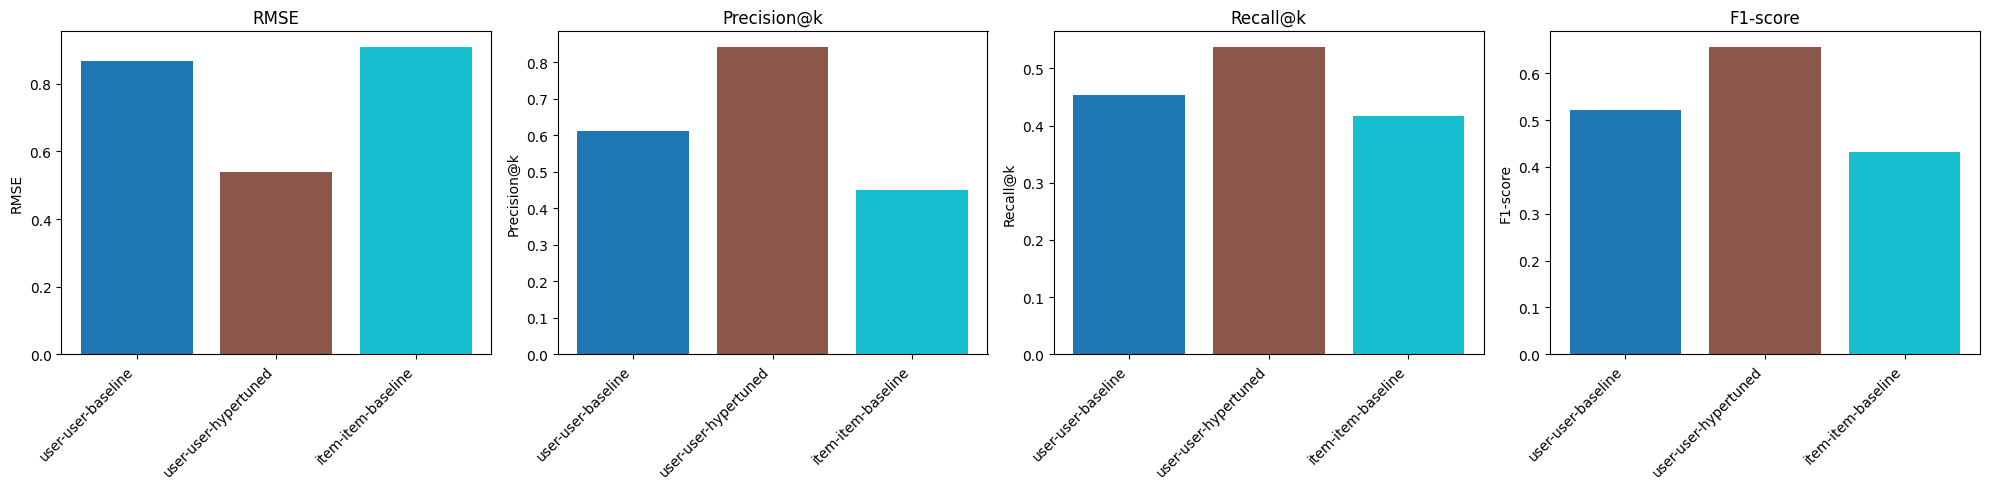

In [187]:
plot_model_comparison_bars_grid(model_comparison_results)

#### Hypertune and Train Item Item Hypertune

* **Includes all user-user measures, plus:**
  * Pearson Baseline → Adjusts for user-specific biases (e.g., some users may rate all songs highly or interact more than others).
* **Why include "pearson_baseline" for items?:**
  * Item-item models generally have denser data than user-user models (since songs get multiple plays across users). The baseline correction helps normalize interactions by accounting for global trends and user biases, improving similarity calculations.

In [188]:
# Define the parameter grid
param_grid = {
    "k": [20, 40, 60, 80],  # Number of neighbors
    "sim_options": {
        "name": ["cosine", "pearson", "msd", "pearson_baseline"],
        "user_based": [False]  # Item-Item CF
    }
}

# Initialize GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(KNNBaseline, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

# Fit the grid search model using the entire dataset
grid_search.fit(data)

# Retrieve the best RMSE score
best_rmse = grid_search.best_score["rmse"]
print(f"Best RMSE Score: {best_rmse:.4f}")

# Retrieve the best parameter combination
best_params = grid_search.best_params["rmse"]
print("Best Parameters:", best_params)

Best RMSE Score: 1.0224
Best Parameters: {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': False}}


In [189]:
model_name = "item-item-hypertuned"

# Train the best model found in grid search
best_k = best_params["k"]
best_sim_options = best_params["sim_options"]

# Initialize the optimized model
item_item_hypertuned_model = KNNBaseline(k=best_k, sim_options=best_sim_options)

# Train the model on the trainset
item_item_hypertuned_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute Precision@30, Recall@30, and F1 Score@30
precision_recall_at_k(model=item_item_hypertuned_model, model_name=model_name, testset=testset, k=best_k)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


{'RMSE': 0.9098791272077277,
 'Precision@k': 0.447,
 'Recall@k': 0.423,
 'F1-score': 0.435}

**Minimal improvement over Item-Item Baseline; underperforms vs. User-User models**:
* Remains weaker in ranking and accuracy, making it a less effective approach for recommendations.
*  Precision@k (0.44) and Recall@k (0.42) are almost identical to the baseline (0.44/0.41); same F1-score (0.43 vs. 0.43).
* The RMSE (0.910) remains unchanged, meaning the model still struggles with accurate play count predictions.


In [190]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
make_and_store_prediction(
    item_item_hypertuned_model,
    'item_item_hypertuned',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    actual_play_count=SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
#  Predict the play_count by a user(user_id 6958) for an unheard song
make_and_store_prediction(
    item_item_hypertuned_model,
    'item_item_hypertuned',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
make_and_store_prediction(
    item_item_hypertuned_model,
    'item_item_hypertuned',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

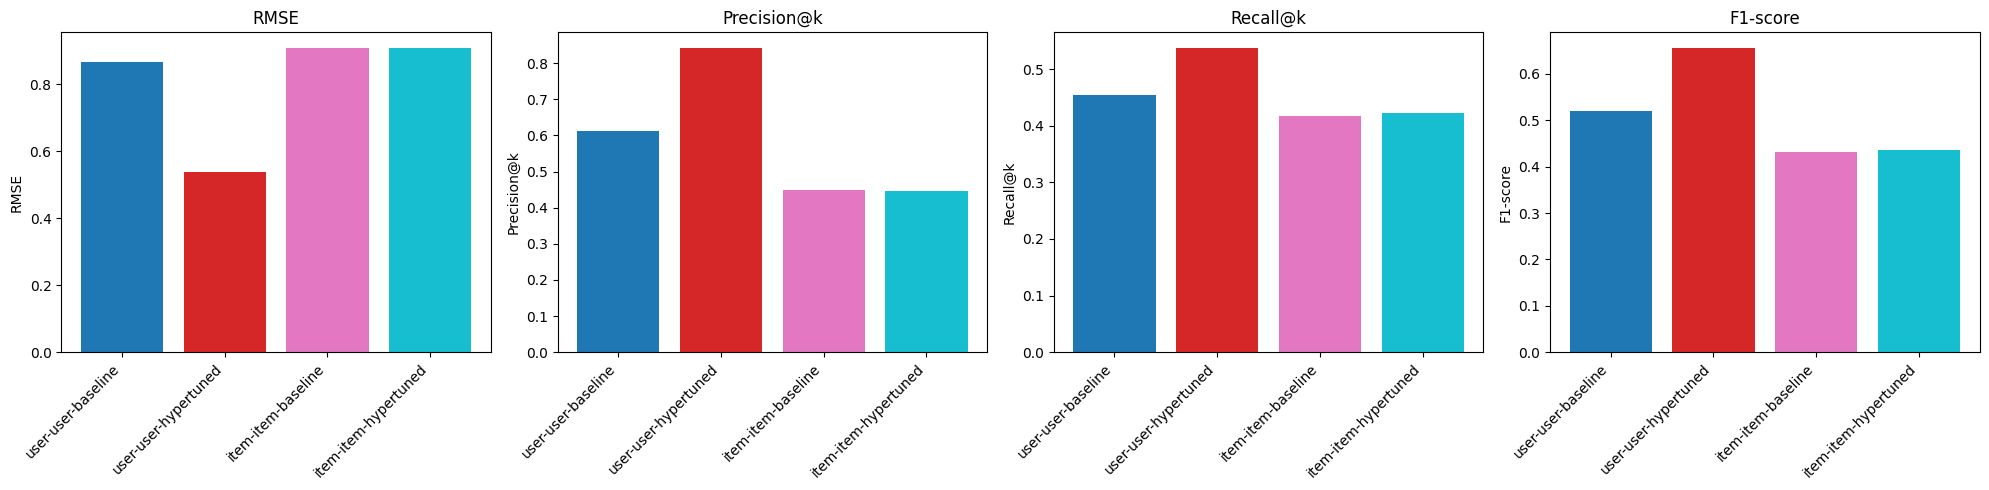

In [191]:
plot_model_comparison_bars_grid(model_comparison_results)

#### Find Similar Songs Using Item-Item CF

In [192]:
item_item_similar_songs_metadata = get_similar_songs_metadata(
    model=item_item_hypertuned_model,
    trainset=trainset,
    df_final=df_final,
    df_columns=df_columns,
    inner_id=0,  # Reference song
    k=5  # Get 5 nearest songs
)

display(item_item_similar_songs_metadata.head())

,song_id,user_id,play_count,title,artist_name,release,year,implicit_score
227,2425,6958,1,Señorita,Justin Timberlake,Justified,2002,1
281,8029,6958,1,I CAN'T GET STARTED,Ron Carter,It's The Time,0,1
948,3770,56576,1,Me & Mr Jones,Amy Winehouse,Me & Mr Jones,2006,1
4025,3770,46525,2,Me & Mr Jones,Amy Winehouse,Me & Mr Jones,2006,2
4042,4761,46525,2,You Know I'm No Good,Amy Winehouse,You Know I'm No Good - GFK Version,2006,2


#### Generating Personalized Song Recommendations
* Predicted play still sits around the global mean and results are very similar to best user to user model recommendations.

In [193]:
# Generate top 5 recommendations for a sample user
sample_user_one_item_item_recommendations = get_recommendations(df=df_final, trainset=trainset, user_id=SAMPLE_USER_ONE, model=item_item_hypertuned_model, top_n=5)

# Display recommendations
display(sample_user_one_item_item_recommendations)

User 6958 (Internal ID: 0) - Heard: 39, Unseen: 524


,user_id,song_id,play_count,title,release,artist_name,year,implicit_score,predicted_play_count
0,27018,6964,1,Is This It,Is This It,The Strokes,2001,1,1.699466
1,27018,7878,2,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466
2,44689,5823,1,We Are The Sleepyheads,The Life Pursuit,Belle & Sebastian,2006,1,1.699466
3,35457,4134,3,Have You Ever Seen The Rain,Chronicle: 20 Greatest Hits,Creedence Clearwater Revival,1971,2,1.699466
4,40245,2161,1,The Last Song,The All-American Rejects,The All-American Rejects,2003,1,1.699466


In [194]:
item_item_playing_count_df = get_play_counts(df_final, sample_user_one_item_item_recommendations, agg_method="max")

# Apply ranking function
ranked_recommendations_display = ranking_songs(sample_user_one_item_item_recommendations, item_item_playing_count_df)
display(ranked_recommendations_display.head())

,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,27018,6964,Is This It,Is This It,The Strokes,2001,1,1.699466,5,1.252252
1,27018,7878,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466,5,1.252252
2,44689,5823,We Are The Sleepyheads,The Life Pursuit,Belle & Sebastian,2006,1,1.699466,5,1.252252
3,35457,4134,Have You Ever Seen The Rain,Chronicle: 20 Greatest Hits,Creedence Clearwater Revival,1971,2,1.699466,5,1.252252
4,40245,2161,The Last Song,The All-American Rejects,The All-American Rejects,2003,1,1.699466,5,1.252252


### Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

#### Train Baseline SVD

In [195]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define model name
model_name = "svd_baseline"

# Initialize the SVD model with default parameters + fixed random state
svd_model = SVD(random_state=42)

# Train the model on the trainset
svd_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute Precision@30, Recall@30, and F1 Score
precision_recall_at_k(model=svd_model, model_name=model_name, testset=testset)

{'RMSE': 0.7189161304872028,
 'Precision@k': 0.744,
 'Recall@k': 0.572,
 'F1-score': 0.647}

**SVD outperforms all item-based models and ranks second overall**
* SVD ranks just behind the user-user hypertuned model.
* Its precision and recall are slightly lower than the top model
* It maintains a strong F1-score (0.650) with a lower RMSE than user-user-baseline, making it a well-balanced choice.

In [196]:
# # Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
make_and_store_prediction(
    svd_model,
    'svd',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
 # Making prediction for user (with user_id 6958) to unheard song
make_and_store_prediction(
    svd_model,
    'svd',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
make_and_store_prediction(
    svd_model,
    'svd',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

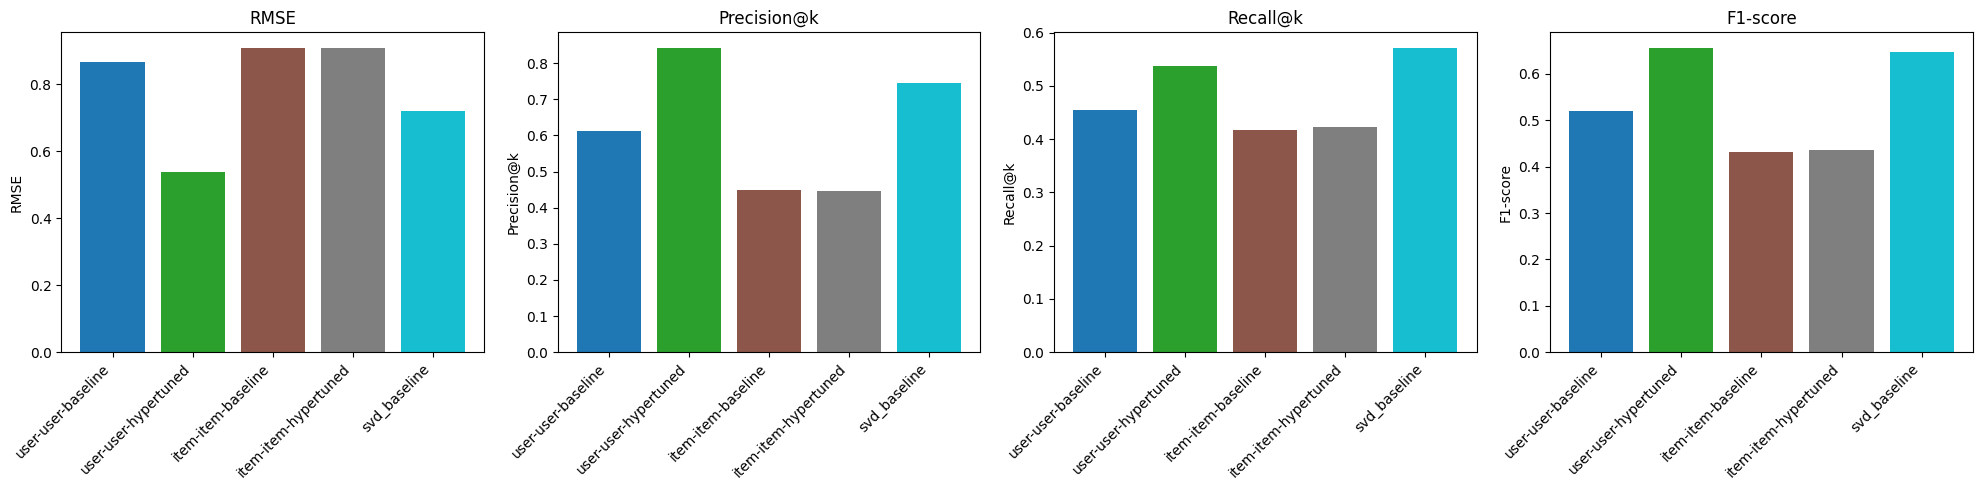

In [197]:
plot_model_comparison_bars_grid(model_comparison_results)

#### Hypertune and Train SVD Hypertuned

Compared to the baseline SVD model, this hypertuned version adjusts factorization complexity, learning speed, and overfitting control for better recommendations.

In [198]:
# Define the parameter grid for tuning
param_grid = {
    "n_factors": [50, 100, 150],  # Number of latent factors
    "lr_all": [0.002, 0.005, 0.01],  # Learning rate
    "reg_all": [0.02, 0.05, 0.1]  # Regularization term
}

# Initialize GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

# Fit the grid search model using the entire dataset
grid_search.fit(data)

# Retrieve the best RMSE score
best_rmse = grid_search.best_score["rmse"]
print(f"Best RMSE Score: {best_rmse:.4f}")

# Retrieve the best parameter combination
best_params = grid_search.best_params["rmse"]
print("Best Parameters:", best_params)

Best RMSE Score: 1.0034
Best Parameters: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}


In [199]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define model name
model_name = "svd_hypertuned"

# Building the optimized SVD model using optimal hyperparameters
best_svd_model = SVD(
    n_factors=best_params["n_factors"],
    lr_all=best_params["lr_all"],
    reg_all=best_params["reg_all"],
    random_state=42  # Ensures consistent results
)

# Train the model on the trainset
best_svd_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute Precision@30, Recall@30, and F1 Score
precision_recall_at_k(model=best_svd_model, model_name=model_name, testset=testset)

{'RMSE': 0.7114300668162803,
 'Precision@k': 0.756,
 'Recall@k': 0.568,
 'F1-score': 0.649}

**Minimal Improvement from Hypertuning**:
* RMSE only drops slightly (0.72 → 0.71), Precision@k improves marginally (0.74 → 0.75), while Recall@k slightly decreases (0.57 → 0.57), indicating limited gains.
* Item-Item Baseline and Hypertuned are still weakest approach so far.

In [200]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
make_and_store_prediction(
    best_svd_model,
    'svd_hypertuned',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
# Using svd_algo_optimized model to recommend for userId 6958 and unheard song
make_and_store_prediction(
    best_svd_model,
    'svd_hypertuned',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
make_and_store_prediction(
    best_svd_model,
    'svd_hypertuned',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

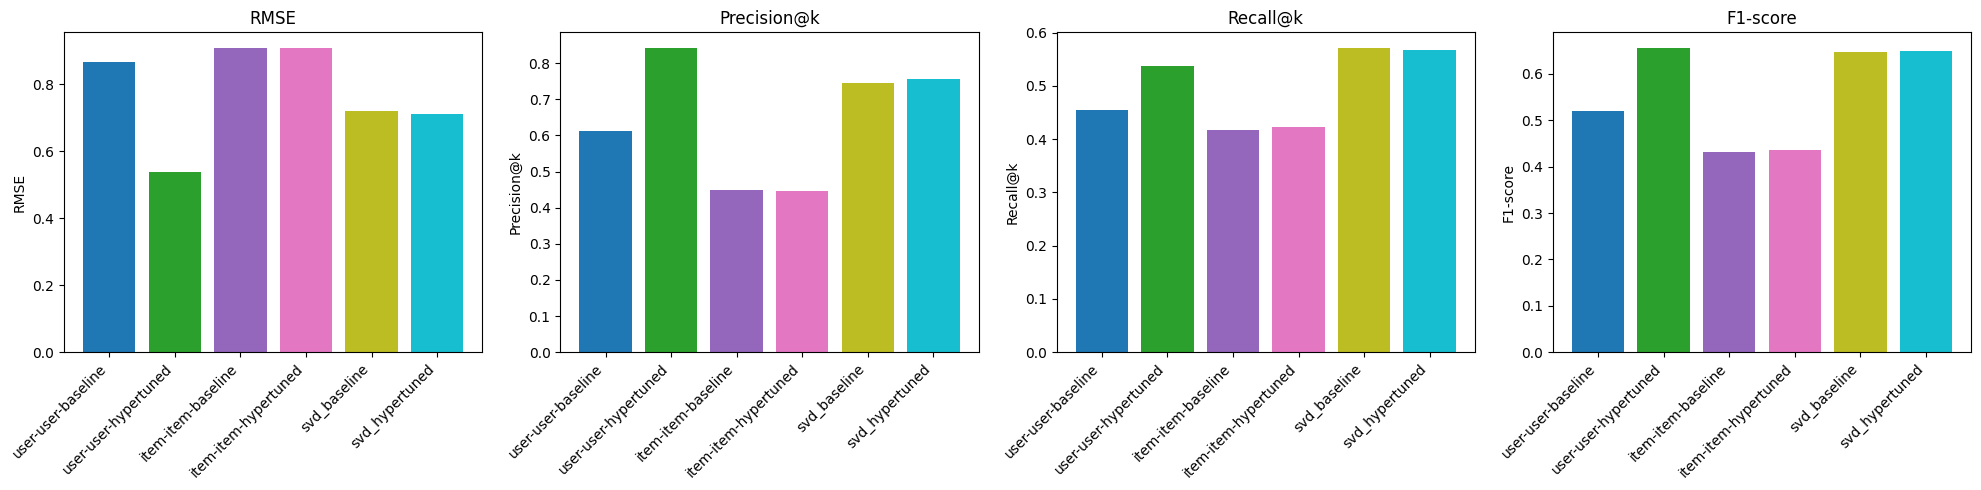

In [201]:
plot_model_comparison_bars_grid(model_comparison_results)

**For user predictions at large:**
* Predicted play counts are lower that prevoius models
* Corrected playcounts deviate from the global mean more than previous models as well.

In [202]:
# Generate top 5 recommendations
sample_user_one_svd_recommendations = get_recommendations(df=df_final, trainset=trainset, user_id=SAMPLE_USER_ONE, model=best_svd_model, top_n=5)

User 6958 (Internal ID: 0) - Heard: 39, Unseen: 524


In [203]:
svd_playing_count_df = get_play_counts(df_final, sample_user_one_svd_recommendations, agg_method="max")

# Apply ranking function
ranked_recommendations_display = ranking_songs(sample_user_one_svd_recommendations, svd_playing_count_df)
display(ranked_recommendations_display.head())

,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,27018,6964,Is This It,Is This It,The Strokes,2001,1,1.699466,5,1.252252
1,27018,7878,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466,5,1.252252
2,44689,5823,We Are The Sleepyheads,The Life Pursuit,Belle & Sebastian,2006,1,1.699466,5,1.252252
3,35457,4134,Have You Ever Seen The Rain,Chronicle: 20 Greatest Hits,Creedence Clearwater Revival,1971,2,1.699466,5,1.252252
4,40245,2161,The Last Song,The All-American Rejects,The All-American Rejects,2003,1,1.699466,5,1.252252


**Hypertune without CVGRID**

In [204]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define model name
model_name = "svd_hypertuned_2"

# Manually specified better hyperparameters based on newer findings
svd_hypertuned_2 = SVD(
    n_factors=150,
    lr_all=0.006,
    reg_all=0.03,
    random_state=42
)

# Train the model on the trainset
svd_hypertuned_2.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute Precision@30, Recall@30, and F1 Score
precision_recall_at_k(model=svd_hypertuned_2, model_name=model_name, testset=testset)

{'RMSE': 0.5979938561560993,
 'Precision@k': 0.828,
 'Recall@k': 0.624,
 'F1-score': 0.712}

In [205]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
make_and_store_prediction(
    svd_hypertuned_2,
    'svd_hypertuned_2',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
# Using svd_algo_optimized model to recommend for userId 6958 and unheard song
make_and_store_prediction(
    svd_hypertuned_2,
    'svd_hypertuned_2',
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
make_and_store_prediction(
    svd_hypertuned_2,
    'svd_hypertuned_2',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

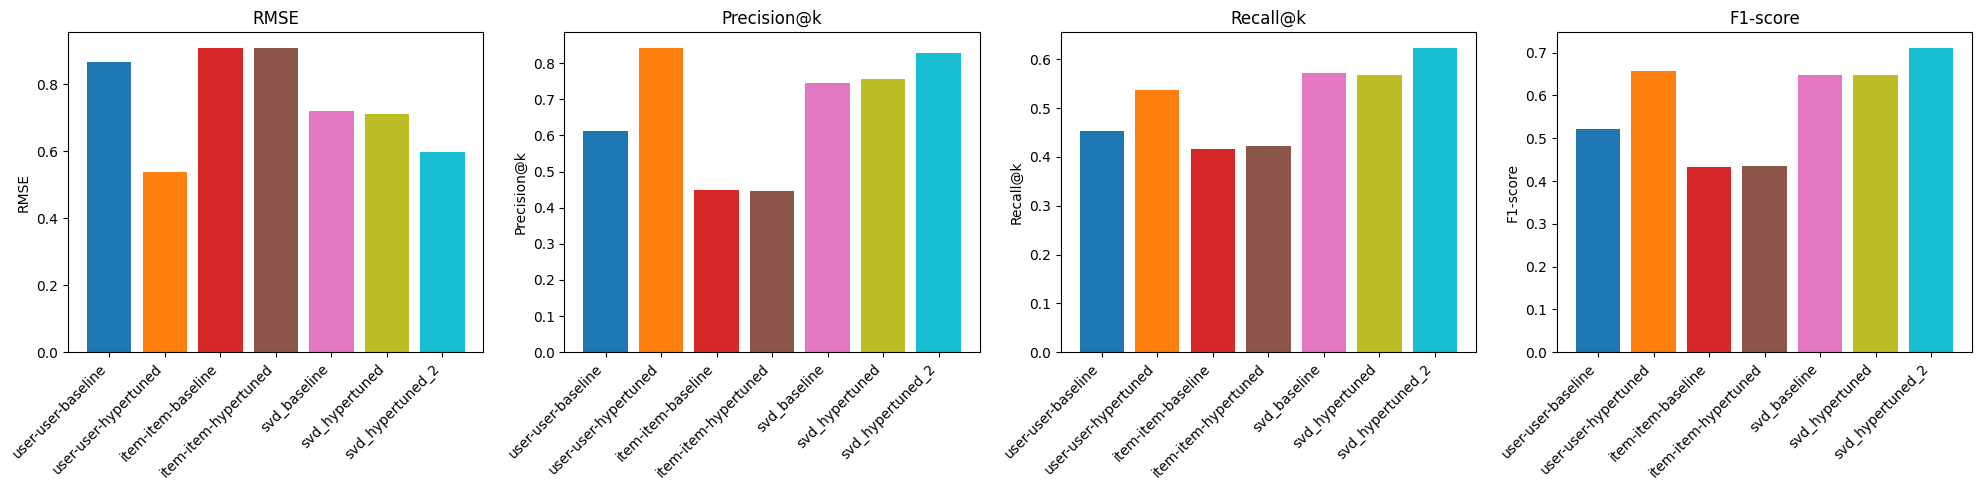

In [206]:
plot_model_comparison_bars_grid(model_comparison_results)

In [207]:
pretty_print_model_evaluations(model_comparison_results)

,Model,RMSE,Precision@k,Recall@k,F1-score
0,user-user-baseline,0.867287,0.611,0.454,0.521
1,user-user-hypertuned,0.537747,0.843,0.538,0.657
2,item-item-baseline,0.909879,0.449,0.417,0.432
3,item-item-hypertuned,0.909879,0.447,0.423,0.435
4,svd_baseline,0.718916,0.744,0.572,0.647
5,svd_hypertuned,0.711430,0.756,0.568,0.649
6,svd_hypertuned_2,0.597994,0.828,0.624,0.712


In [208]:
# Generate top 5 recommendations
sample_user_one_svd_2_recommendations = get_recommendations(df=df_final, trainset=trainset, user_id=SAMPLE_USER_ONE, model=svd_hypertuned_2, top_n=15)
sample_user_one_svd_2_playing_count_df = get_play_counts(df_final, sample_user_one_svd_recommendations, agg_method="max")

# Apply ranking function
sample_user_one_svd_2_ranked_recommendations_display = ranking_songs(sample_user_one_svd_2_recommendations, svd_playing_count_df)
display(ranked_recommendations_display.head())

User 6958 (Internal ID: 0) - Heard: 39, Unseen: 524


,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,27018,6964,Is This It,Is This It,The Strokes,2001,1,1.699466,5,1.252252
1,27018,7878,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466,5,1.252252
2,44689,5823,We Are The Sleepyheads,The Life Pursuit,Belle & Sebastian,2006,1,1.699466,5,1.252252
3,35457,4134,Have You Ever Seen The Rain,Chronicle: 20 Greatest Hits,Creedence Clearwater Revival,1971,2,1.699466,5,1.252252
4,40245,2161,The Last Song,The All-American Rejects,The All-American Rejects,2003,1,1.699466,5,1.252252


In [209]:
most_active = 61472
sample_user_active_svd_2_recommendations = get_recommendations(
    df=df_final,
    user_id=most_active,
    model=svd_hypertuned_2,
    trainset=trainset,
    top_n=15
)
sample_user_active_svd_2_playing_count_df = get_play_counts(df_final, sample_user_most_active_best_user_user_recommendations, agg_method="max")

# Apply ranking function
sample_user_active_svd_2_ranked_recommendations = ranking_songs(sample_user_most_active_best_user_user_recommendations, most_active_playing_count_df)
display(most_active_cf_ranked_recommendations.head())

User 61472 (Internal ID: 313) - Heard: 243, Unseen: 320


,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,6958,1818,Teenager,Modapop,Camera Obscura,0,1,1.699466,5,1.252252
1,6958,5340,Postcards From Italy,The Gulag Orkestar,Beirut,2005,1,1.699466,5,1.252252
2,27018,1682,Tuxedo Hat,One Ten Hundred Thousand Million,Octopus Project,2005,2,1.699466,5,1.252252
3,27018,4724,Tortured Soul,Skream!,Skream,2006,3,1.699466,5,1.252252
4,27018,6618,Meteor,Ray Guns Are Not Just The Future,the bird and the bee,2009,1,1.699466,5,1.252252


#### **Observations**
* Lowest RMSE (0.598) — strongest reduction in prediction error across all models
* Highest Precision@k (0.831) — most relevant top-ranked recommendations
* Highest Recall@k (0.632) — captures the greatest proportion of relevant items
* Best F1-score (0.718) — optimal balance between precision and recall

Significant improvement over both svd_baseline and original svd_hypertuned models. Addtionally, this model clearly outperforms all others in both error reduction and top-k ranking quality.

**Why?**
* Lower lr_all (0.006) allowed for more gradual updates during training, which can improve convergence stability and prevent overshooting optimal values, especially with more latent factors.
* Reduced reg_all (0.03) applied less regularization, letting the model capture more nuanced patterns in user-item interactions—useful when the dataset is dense or the added complexity from n_factors=150 is well-supported by the data.

This manual tuning bypassed GridSearchCV’s coarse steps and allowed finer-grained control over learning dynamics.

### Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

**Clusters Lack Clear Separation**
* A KMeans inertia of 25,452.14 indicates moderate cluster cohesion, meaning points are not tightly grouped.
* The silhouette score of 0.063 suggests weakly defined clusters with significant overlap, implying that the data does not naturally separate into distinct groups, making clustering less effective for recommendation purposes.

In [210]:
model_name = "cluster_baseline"

# Train cluster_model Model using Surprise's trainset
cluster_model = SVD(n_factors=10, random_state=42)
cluster_model.fit(trainset)

# Extract User Embeddings and Convert to Pandas
user_factors = {trainset.to_raw_uid(uid): cluster_model.pu[uid] for uid in trainset.all_users()}
user_factors_df = pd.DataFrame.from_dict(user_factors, orient="index")
user_factors_df.index.name = "user_id"

# Normalize User Embeddings for Clustering
scaler = StandardScaler()
user_factors_scaled = scaler.fit_transform(user_factors_df)

# Cluster Users using KMeans
n_clusters = 5  # Can be tuned
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
user_factors_df["cluster"] = kmeans.fit_predict(user_factors_scaled)

# Evaluate Cluster Quality
inertia = kmeans.inertia_  # Measures compactness
silhouette = silhouette_score(user_factors_scaled, user_factors_df["cluster"])
print(f"KMeans Inertia: {inertia}")
print(f"Silhouette Score: {silhouette}")

# Create a User-Cluster Mapping
user_clusters = user_factors_df["cluster"].to_dict()

KMeans Inertia: 25618.417215825895
Silhouette Score: 0.06344789644867489


In [211]:
# Making prediction for user_id 6958 and song_id 1671
make_and_store_prediction(
    cluster_model,
    model_name,
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
# # Making prediction for user (userid 6958) for a song(song_id 3232) not listened to by the user
make_and_store_prediction(
    cluster_model,
    model_name,
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
make_and_store_prediction(
    cluster_model,
    model_name,
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

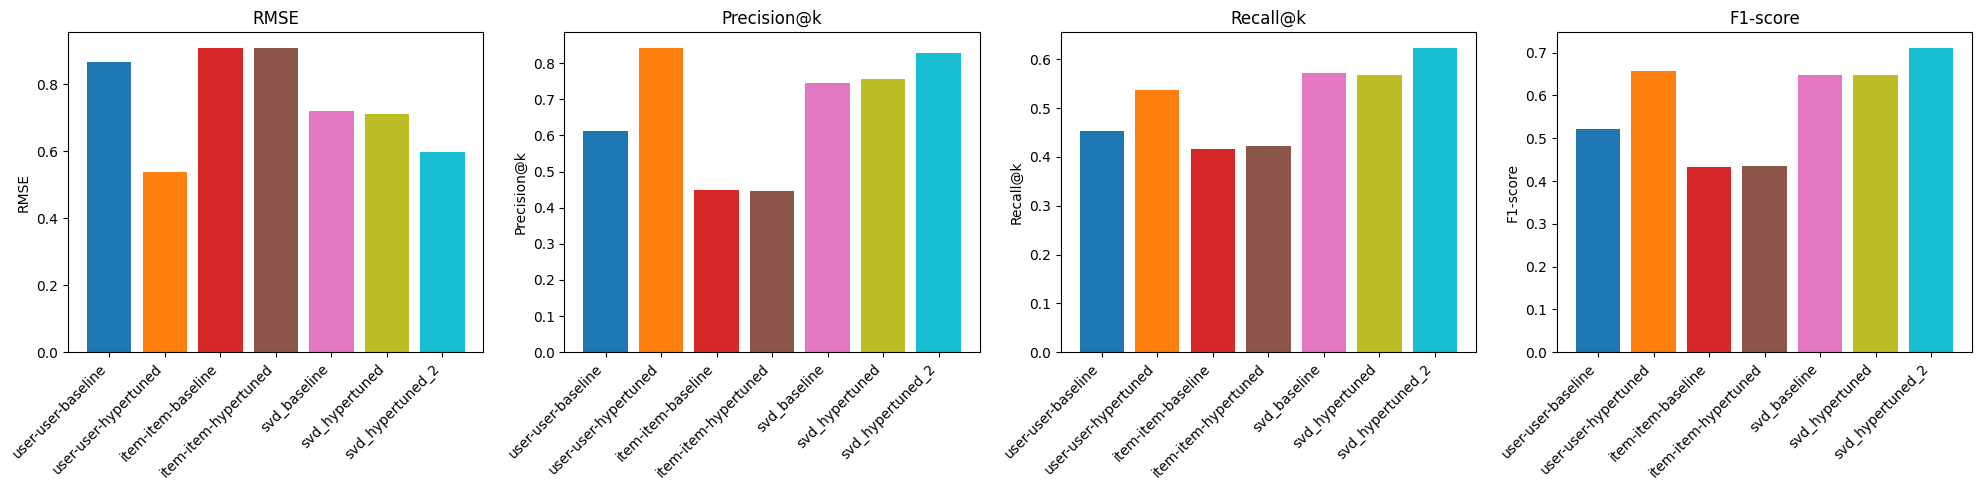

In [212]:
plot_model_comparison_bars_grid(model_comparison_results)

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [213]:
# Step 1: Set the parameter space to tune
param_grid = {
    'n_factors': [5, 10, 20, 50],  # Number of latent factors
    'reg_all': [0.01, 0.02, 0.05, 0.08, 0.1],  # Regularization strength
    'lr_all': [0.001, 0.002, 0.005, 0.007, 0.01]  # Learning rate
}

# Step 2: Perform 3-fold grid search cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Step 3: Fitting data
gs.fit(data)

# Step 4: Retrieve all evaluation scores
results_df = pd.DataFrame.from_dict(gs.cv_results)

# Step 5: Extract Best Parameters & Best RMSE Score
best_rmse_score = gs.best_score['rmse']
best_params = gs.best_params['rmse']

print(f"Best RMSE score: {best_rmse_score}")
print(f"Best parameter combination for RMSE: {best_params}")

# Step 6: Train the best SVD model
svd = SVD(**best_params, random_state=42)
svd.fit(trainset)  # Use the same trainset from before

Best RMSE score: 0.9982406761652957
Best parameter combination for RMSE: {'n_factors': 50, 'reg_all': 0.08, 'lr_all': 0.01}


**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [214]:
# # === Co-Clustering Hyperparameter Tuning with GridSearchCV ===
# Set seed for reproducibility
np.random.seed(42)

# === Co-Clustering Hyperparameter Tuning with GridSearchCV ===
model_name = "co_cluster"

# Define parameter grid for CoClustering
param_grid = {
    'n_cltr_u': [2, 3, 5, 7, 10],  # Number of user clusters
    'n_cltr_i': [2, 3, 5, 7, 10],  # Number of item clusters
    'n_epochs': [20, 40, 60]  # Number of training iterations
}

# Perform 3-fold GridSearchCV with parallel processing
gs_coclustering = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1, joblib_verbose=3)

# Fit GridSearchCV on the Surprise dataset
gs_coclustering.fit(data)

# Convert results to DataFrame
coclustering_results_df = pd.DataFrame.from_dict(gs_coclustering.cv_results)

# Retrieve the best hyperparameters & RMSE score
best_rmse_coclustering = gs_coclustering.best_score['rmse']
best_params_coclustering = gs_coclustering.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  1.8min finished


In [215]:
# === Train & Evaluate the Best Co-Clustering Model ===

# Define model name
model_name = "co_clustering_hypertuned"

# Train the best CoClustering model
co_cluster_model = CoClustering(**best_params_coclustering, random_state=42)
co_cluster_model.fit(trainset)

# Generate the testset from the trainset
testset = trainset.build_testset()  # Ensure testset is created

# Compute Precision@30, Recall@30, and F1 Score
coclustering_results = precision_recall_at_k(
    model=co_cluster_model,
    model_name=model_name,
    testset=testset
)

**Co-Clustering Hypertuned underperforms compared to SVD and User-User models**
* Higher RMSE (0.94) and lower Precision@K (0.50) indicates weaker recommendation accuracy and ranking effectiveness.
* Slightly better than Item-Item models in Recall@K (0.47 vs. 0.42) but still struggles overall, suggesting it may expose users to new content but lacks strong personalization compared to SVD or User-User Hypertuned.

In [216]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
make_and_store_prediction(
    co_cluster_model,
    model_name,
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_HEARD,
    SAMPLE_USER_ONE_SONG_HEARD_PLAY_COUNT
)
# Using co_clustering_optimized model to recommend for userId 6958 and unheard song
make_and_store_prediction(
    co_cluster_model,
    model_name,
    SAMPLE_USER_ONE,
    SAMPLE_USER_ONE_SONG_UNHEARD
)
# Make and store all predictions for user two
make_and_store_prediction(
    co_cluster_model,
    'co_cluster',
    SAMPLE_USER_TWO,
    SAMPLE_USER_TWO_SONG_UNHEARD
)

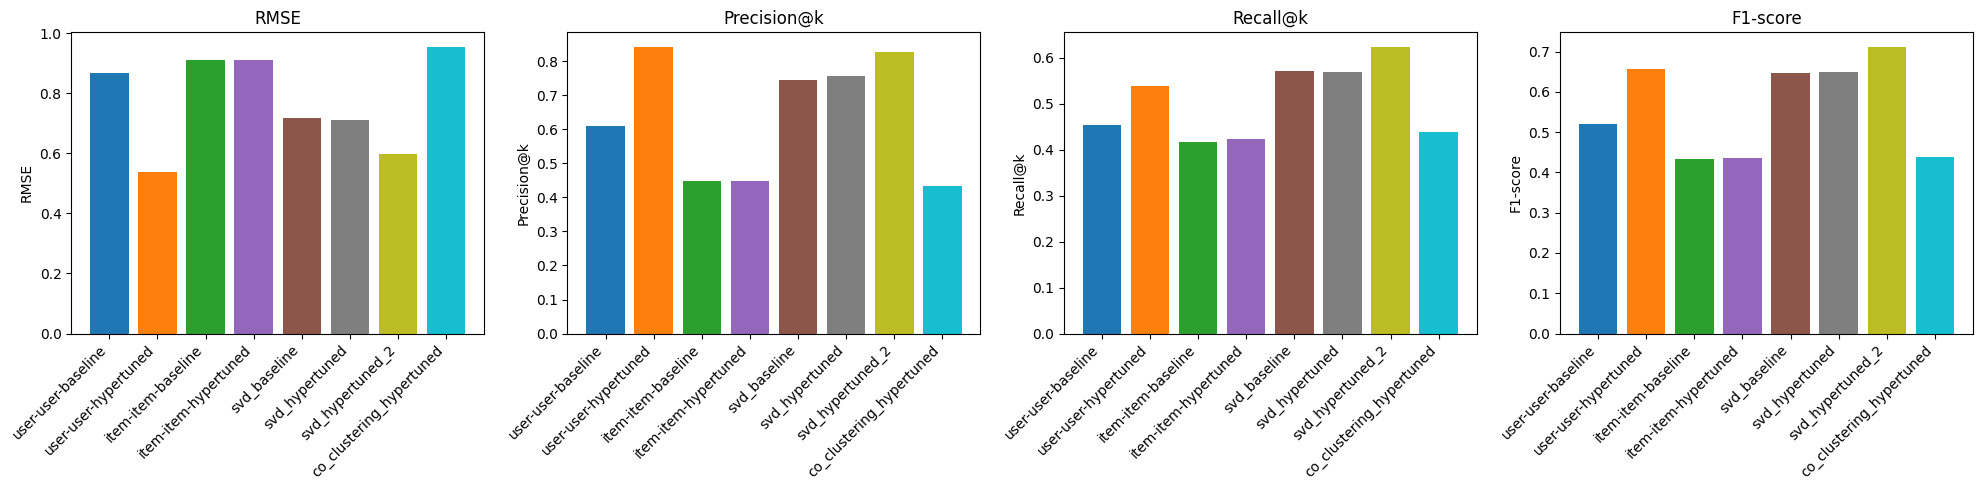

In [217]:
plot_model_comparison_bars_grid(model_comparison_results)

#### Implementing the recommendation algorithm based on optimized CoClustering model

* Recommendations are highly influenced by the global play count distribution
  * The top 5 recommended songs have **similar estimated play counts**, suggesting that the model relies on overall song popularity rather than strong user preference signals.  

* Ranking adjustments provide more refined recommendations**
  * Applying corrections using actual play counts reorders the recommendations, potentially reducing bias toward frequently played songs.  

* Personalization remains limited
  * Since Co-Clustering groups users and items into clusters, recommendations are generalized within clusters rather than individually tailored.


In [218]:
# Display the top 5 recommendations with full song details
sample_user_one_cocluster_recommendations = get_recommendations(df=df_final, trainset=trainset, user_id=SAMPLE_USER_ONE, model=co_cluster_model, top_n=5)

User 6958 (Internal ID: 0) - Heard: 39, Unseen: 524


### Correcting the play_count and Ranking the above songs

In [219]:
playing_count_df = get_play_counts(df_final, sample_user_one_cocluster_recommendations, agg_method="max")

# Apply ranking function
ranked_recommendations_display = ranking_songs(sample_user_one_cocluster_recommendations, playing_count_df)
display(ranked_recommendations_display.head())

,user_id,song_id,title,release,artist_name,year,implicit_score,predicted_play_count,play_count,corrected_play_count
0,27018,6964,Is This It,Is This It,The Strokes,2001,1,1.699466,5,1.252252
1,27018,7878,Don't Panic,Don't Panic,Coldplay,1999,2,1.699466,5,1.252252
2,44689,5823,We Are The Sleepyheads,The Life Pursuit,Belle & Sebastian,2006,1,1.699466,5,1.252252
3,35457,4134,Have You Ever Seen The Rain,Chronicle: 20 Greatest Hits,Creedence Clearwater Revival,1971,2,1.699466,5,1.252252
4,40245,2161,The Last Song,The All-American Rejects,The All-American Rejects,2003,1,1.699466,5,1.252252


### Collaborative Filtering - Interpreting Results

### **Evaluating Model Performance**  

To compare model effectiveness, we evaluate predictions across multiple recommendation techniques. The following visuals present:  

- **Per-User Predictions** → A breakdown of how different models predict play counts for individual users, highlighting variation across techniques.  
- **Error Analysis** → Comparison of predicted vs. actual play counts where available, illustrating model accuracy.  
- **Overall Performance Metrics** → RMSE, Precision@k, Recall@k, and F1-score for each model, helping assess trade-offs between accuracy and relevance.  

Key observations to keep in mind:  

- **User-User Collaborative Filtering (Hypertuned) consistently outperforms the baseline** across all metrics, demonstrating the value of fine-tuning similarity-based recommendations.  
- **SVD models achieve strong balance between RMSE and precision**, indicating that matrix factorization effectively captures latent user-song relationships.  
- **Item-Item and Co-Clustering models show higher RMSE and lower recall**, suggesting they are less effective at handling data sparsity in this dataset.  

These insights guide the selection of the best approach for integrating into the hybrid recommendation system.  


In [220]:
print_predictions_for_user(SAMPLE_USER_ONE)
print_predictions_for_user(SAMPLE_USER_TWO)


Predictions for User 6958:
                   Model  Song ID  Predicted Play Count Actual Play Count Prediction Error
      user-user-baseline     1671                  1.62                 2             0.38
      user-user-baseline     3232                  1.35               N/A              N/A
    user-user-hypertuned     1671                  1.38                 2             0.62
    user-user-hypertuned     3232                  1.34               N/A              N/A
      item_item_baseline     1671                  1.26                 2             0.74
      item_item_baseline     3232                  1.38               N/A              N/A
    item_item_hypertuned     1671                  1.26                 2             0.74
    item_item_hypertuned     3232                  1.38               N/A              N/A
                     svd     1671                  1.26                 2             0.74
                     svd     3232                  1.22       

In [221]:
pretty_print_model_evaluations(model_comparison_results)

,Model,RMSE,Precision@k,Recall@k,F1-score
0,user-user-baseline,0.867287,0.611,0.454,0.521
1,user-user-hypertuned,0.537747,0.843,0.538,0.657
2,item-item-baseline,0.909879,0.449,0.417,0.432
3,item-item-hypertuned,0.909879,0.447,0.423,0.435
4,svd_baseline,0.718916,0.744,0.572,0.647
5,svd_hypertuned,0.711430,0.756,0.568,0.649
6,svd_hypertuned_2,0.597994,0.828,0.624,0.712
7,co_clustering_hypertuned,0.955366,0.435,0.439,0.437


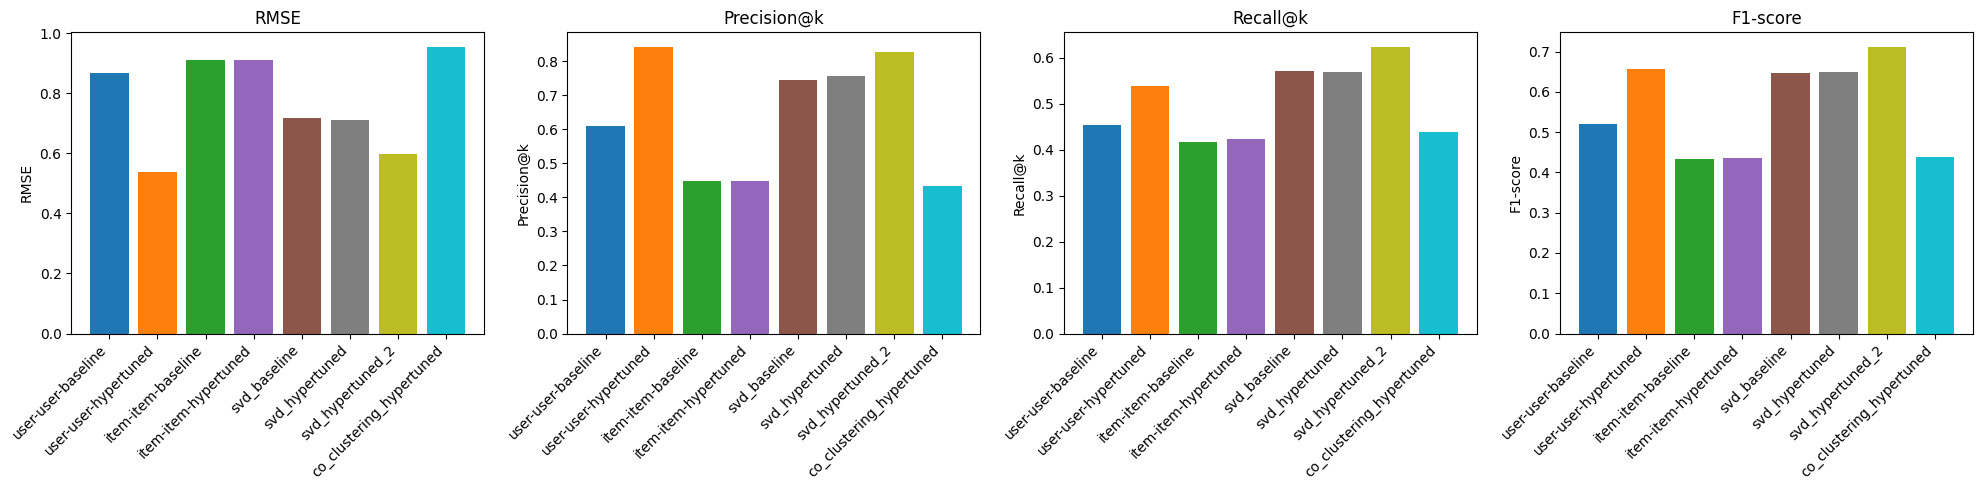

In [222]:
plot_model_comparison_bars_grid(model_comparison_results)

### Content Based Recommendation Systems

So far, our recommendations have relied solely on play count, but songs contain rich metadata that we can leverage to improve recommendations. Using text-based features, we will build a content-based filtering model that takes a song title as input and returns a list of similar songs based on textual attributes using TF-IDF vectorization.

**Steps for Content-Based Modeling:**
1. Use the original cleaned and merged dataset (before filtering for collaborative models).
2. Impute missing years using KMeans clustering to maintain consistency in temporal features.
3. Create a "decade" feature from the year field to capture temporal song trends.
4. Generate a text-based representation by concatenating key song metadata (e.g., title, artist, release).
5. Apply TF-IDF vectorization to transform the text data into numerical representations.
6. Build a recommendation system that takes a song title as input and returns the most similar songs based on textual content rather than user interaction history.

**Content Dataset**:

* For content-based filtering, reducing the dataset limits recommendation quality rather than improving it. Using all 2M records ensures better feature extraction, richer recommendations, and greater diversity in suggested songs.

In [223]:
# We are using all 2M to build this model
df_content.shape

(2000000, 7)

**Handle Missing Years**
* Since this is valuable metadata for songs, we will try to impute the values from songs in the same cluster and decide on the number of clusters  with KMeans clustering.

In [224]:
# Assert missing years still exist
assert (df_content["year"] == 0).sum() != 0, "There are still missing years!"

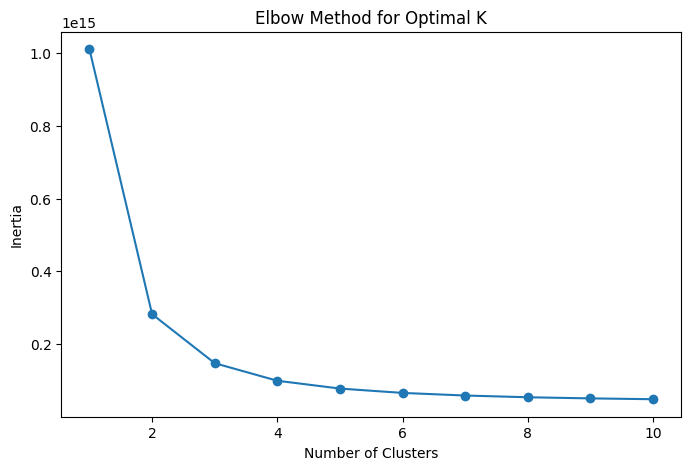

In [225]:
# Select features relevant for clustering (excluding 'year' temporarily if missing)
features = df_content.drop(columns=['year'])  # Adjust based on your dataset

# Separate numeric and categorical features
numeric_features = features.select_dtypes(include=[np.number])
categorical_features = features.select_dtypes(exclude=[np.number])

# Fill missing numeric values with the mean
numeric_features = numeric_features.fillna(numeric_features.mean())

# Convert categorical features to numerical using Label Encoding
label_encoders = {}
for col in categorical_features.columns:
    le = LabelEncoder()
    categorical_features[col] = le.fit_transform(categorical_features[col].astype(str))
    label_encoders[col] = le  # Store encoder for potential inverse transform

# Combine processed numerical and categorical features
processed_features = pd.concat([numeric_features, categorical_features], axis=1)

# Determine the optimal number of clusters using the elbow method
inertia = []
K_range = range(1, 11)  # Try 1 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(processed_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

**Impute Cluster Year Where Missing**

In [226]:
# Choose optimal K from the elbow plot and fit K-Means
optimal_k = 2  # Adjust this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_content['cluster'] = kmeans.fit_predict(processed_features)

# Impute missing values based on the most common year in each cluster
def impute_year(row):
    if pd.isna(row['year']):
        cluster_years = df_content[df_content['cluster'] == row['cluster']]['year'].dropna()
        if not cluster_years.empty:
            return Counter(cluster_years).most_common(1)[0][0]  # Most frequent year in cluster
    return row['year']

df_content['year'] = df_content.apply(impute_year, axis=1)

# Drop cluster column if not needed
df_content.drop(columns=['cluster'], inplace=True)


**Create Decade Feature**
* The decade of a song is a stronger signal than year alone, so we will add it to our dataframe for content modeling.

In [227]:
# Ensure 'year' column is numeric
df_content['year'] = pd.to_numeric(df_content['year'], errors='coerce')

# Create 'decade' column (floor division by 10, then multiply by 10)
df_content['decade'] = (df_content['year'] // 10) * 10

In [228]:
df_content.head()

,user_id,song_id,play_count,title,release,artist_name,year,decade
0,54961,153,1,The Cove,Thicker Than Water,Jack Johnson,0,0
1,54961,413,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,1970
2,54961,736,1,Stronger,Graduation,Kanye West,2007,2000
3,54961,750,1,Constellations,In Between Dreams,Jack Johnson,2005,2000
4,54961,1188,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,1990


In [229]:
# Ensure df_small_content exists
df_small_content = df_content.copy()

# Store original casing
df_small_content["title_original"] = df_small_content["title"]

# Ensure 'year' & 'decade' only appear if non-zero
def format_year_decade(row):
    year = str(int(row["year"])) if row["year"] != 0 else ""
    decade = str(int(row["decade"])) if row["decade"] != 0 else ""
    return f"{decade} {year}".strip()

# Create text feature (using lowercased versions)
df_small_content["text"] = (
    df_small_content["artist_name"].str.lower().str.strip() + " " +
    df_small_content["title"].str.lower().str.strip() + " " +
    df_small_content["release"].str.lower().str.strip() + " " +
    df_small_content.apply(format_year_decade, axis=1)
)

# Keep only necessary columns
df_small_content = df_small_content[["title", "title_original", "text"]].copy()

# Normalize song titles for indexing
df_small_content["title"] = df_small_content["title"].str.lower().str.strip()

# Create indices mapping (Pandas Series)
indices = pd.Series(df_small_content.index, index=df_small_content["title"]).drop_duplicates()

print("Data Prepared")

Data Prepared


In [230]:
df_small_content.head()

,title,title_original,text
0,the cove,The Cove,jack johnson the cove thicker than water
1,entre dos aguas,Entre Dos Aguas,paco de lucia entre dos aguas flamenco para ni...
2,stronger,Stronger,kanye west stronger graduation 2000 2007
3,constellations,Constellations,jack johnson constellations in between dreams ...
4,learn to fly,Learn To Fly,foo fighters learn to fly there is nothing lef...


In [231]:
# Reduce TF-IDF complexity
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1500)  # Smaller feature space
df_sampled = df_small_content.sample(n=min(30000, len(df_small_content)), random_state=42)  # Sample subset
tfidf_matrix_sampled = tfidf_vectorizer.fit_transform(df_sampled["text"]).astype(np.float32)

# Use `brute` algorithm for cosine similarity (since ball_tree/kd_tree don’t support it)
nn_model = NearestNeighbors(n_neighbors=10, metric="cosine", algorithm="brute", n_jobs=-1)
nn_model.fit(tfidf_matrix_sampled)

# Compute nearest neighbors only for sampled songs
distances, indices_nn = nn_model.kneighbors(tfidf_matrix_sampled)

# Convert distances to similarity scores
tfidf_cosine_sim = 1 - distances

 Finally, let's create a function to find most similar songs to recommend for a given song.

In [232]:
def recommendations(title, tfidf_cosine_sim, indices_nn):
    """
    Recommends songs using TF-IDF cosine similarity with NearestNeighbors.

    Parameters:
    - title (str): The input song title.
    - tfidf_cosine_sim (numpy.ndarray): Cosine similarity scores.
    - indices_nn (numpy.ndarray): Indices of nearest neighbors.

    Returns:
    - DataFrame with recommended songs (original casing, release, and year).
    """
    title = title.lower().strip()

    # Ensure song exists in indices
    if title not in indices:
        return pd.DataFrame(columns=["title_original", "release", "year", "similarity"])

    # Get song index safely
    idx = indices[title]
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    # Get nearest neighbors
    song_indices = indices_nn[idx]
    similarity_scores = tfidf_cosine_sim[idx]

    # Retrieve recommended songs with correct casing and metadata
    recommended_songs = df_content.iloc[song_indices][["title", "release", "year"]].copy()
    recommended_songs["title_original"] = df_content.iloc[song_indices]["title"]  # Preserve casing
    recommended_songs["similarity"] = similarity_scores  # Add similarity score

    return recommended_songs[["title_original", "release", "year", "similarity"]].reset_index(drop=True)

Recommending 10 songs similar to Learn to Fly (*Foo Fighters*)
* Songs returned are both relevant and diverse.

In [233]:
# Run Recommendations
recommendations_tfidf_test = recommendations("Learn To Fly", tfidf_cosine_sim, indices_nn)

# Display Results
print("TF-IDF Recommendations:")
display(recommendations_tfidf_test)

TF-IDF Recommendations:


,title_original,release,year,similarity
0,Todo se transforma (Cara B),Todo se transforma,2008,1.0
1,Meet Virginia,Train,1996,1.0
2,Don't Dink and Drance (Album Version),Plagues,2007,1.0
3,So Nice So Smart,Juno - Music From The Motion Picture [Deluxe],2004,1.0
4,Clementine,Castaways and Cutouts,2002,1.0
5,Este amor,Amatoria,2009,1.0
6,The Whole World,Big Boi & Dre Present_ Outkast,0,1.0
7,A Million Ways,A Million Ways,2005,1.0
8,It's My Life,Crush,2000,1.0
9,Los Angeles_ I'm Yours,Billy Liar (CD-Single),0,1.0


Recommending 10 songs similar to "At The Bottom Of Everything" (*Bright Eyes*)


In [234]:
# Run Recommendations
recommendations_tfidf_test = recommendations("At The Bottom Of Everything", tfidf_cosine_sim, indices_nn)

# Display Results
print("TF-IDF Recommendations:")
display(recommendations_tfidf_test)

TF-IDF Recommendations:


,title_original,release,year,similarity
0,The Scientist,The Scientist,2002,1.000000
1,At The Bottom Of Everything,Motion Sickness,2005,1.000000
2,Tire Swing,Juno - Music From The Motion Picture,2006,1.000000
3,Rock Star,In Search Of...,2002,0.915351
4,Teddy Picker,Favourite Worst Nightmare,2007,0.915351
5,Oh Jungleland,Themes - Volume 5,1985,0.915351
6,No Names (Black Debbie),The Mouse & The Mask,0,0.915351
7,Halo (Explicit Album Version),The Blackening,0,0.915351
8,Amsterdam,A Rush Of Blood To The Head,2002,0.915351
9,Red Light Indicates Doors Are Secured,Whatever People Say I Am_ That's What I'm Not,2006,0.915351


## Hybrid Solution: Best CF (Best User-User) + Content Based + Ranking Based

The final function in this notebook combines the strengths of multiple models to create a well-balanced playlist for a user. It starts by selecting unheard songs predicted by the collaborative filtering model and then refines these recommendations using a content-based approach to find similar tracks. To ensure diversity, the function also includes a few of the most popular songs across all users, striking a balance between personalization and broad appeal.

In [235]:
def generate_hybrid_playlist(
    user_top_cf_recommendations, tfidf_cosine_sim, indices_nn, song_stats,
    df_content, df_columns, top_10_frequent=top_10_frequent, n=5
):
    """
    Generates a hybrid playlist by combining:
    1. Top User-User Collaborative Filtering (CF) recommendations.
    2. Content-Based Filtering (TF-IDF) recommendations for each CF song.
    3. A small selection of highly played songs.

    Returns:
    - pd.DataFrame: Hybrid playlist (Limited to 25 songs, shuffled).
    """

    # Ensure song_id is a string for merging
    df_content_copy = df_content.copy()
    df_content_copy["song_id"] = df_content_copy["song_id"].astype(str)
    song_stats["song_id"] = song_stats["song_id"].astype(str)

    # Normalize title column in `df_content_copy`
    if "title" in df_content_copy.columns:
        df_content_copy["title"] = df_content_copy["title"].str.lower().str.strip()

    # Ensure implicit_score exists
    if "implicit_score" not in df_content_copy.columns:
        df_content_copy["implicit_score"] = 0  # Default value if missing

    # Step 1: Generate TF-IDF Recommendations
    tfidf_recommendations_list = []

    if "title" in user_top_cf_recommendations.columns:
        for song_title in user_top_cf_recommendations["title"]:
            tfidf_recommendations = recommendations(song_title.lower().strip(), tfidf_cosine_sim, indices_nn)

            # Ensure `recommendations()` returns at least `n` recommendations
            if tfidf_recommendations.shape[0] > n:
                tfidf_recommendations = tfidf_recommendations.head(n)

            tfidf_recommendations_list.append(tfidf_recommendations)

    # Check if TF-IDF recommendations exist
    if not tfidf_recommendations_list:
        # print("Warning: No TF-IDF recommendations were generated!")
        tfidf_recommendations_df = pd.DataFrame(columns=user_top_cf_recommendations.columns)
    else:
        tfidf_recommendations_df = pd.concat(tfidf_recommendations_list).drop_duplicates()

    # Step 2: Combine user-user CF and TF-IDF recommendations
    hybrid_playlist = pd.concat([
        user_top_cf_recommendations,  # CF Recommendations
        tfidf_recommendations_df,  # Content-Based Filtering
    ]).reset_index(drop=True)

    # Step 3: Fill in Missing Titles & Artists Using Release + Year Lookup
    missing_mask = hybrid_playlist["artist_name"].isna() | hybrid_playlist["title"].isna()

    if missing_mask.any():
        # print(f"Found {missing_mask.sum()} rows with missing artist/title... Attempting to fix!")

        for idx in hybrid_playlist[missing_mask].index:
            release, year = hybrid_playlist.loc[idx, ["release", "year"]]

            # Try to find a match in TF-IDF DataFrame
            match = tfidf_recommendations_df[
                (tfidf_recommendations_df["release"] == release) &
                (tfidf_recommendations_df["year"] == year)
            ]

            if not match.empty:
                match = match.iloc[0]  # Get the first valid match

                # Fill missing title **only if NaN**
                if pd.isna(hybrid_playlist.at[idx, "title"]) and "title_original" in match:
                    hybrid_playlist.at[idx, "title"] = match["title_original"]

                # Fill missing artist_name **only if NaN**
                if pd.isna(hybrid_playlist.at[idx, "artist_name"]) and "artist_name" in match:
                    hybrid_playlist.at[idx, "artist_name"] = match["artist_name"]

            # 🔹 SECOND ATTEMPT: Lookup artist in `df_content` if still missing
            if pd.isna(hybrid_playlist.at[idx, "artist_name"]):
                content_match = df_content_copy[
                    (df_content_copy["release"] == release) &
                    (df_content_copy["year"] == year)
                ]

                if not content_match.empty and "artist_name" in content_match.columns:
                    hybrid_playlist.at[idx, "artist_name"] = content_match["artist_name"].values[0]

                if pd.isna(hybrid_playlist.at[idx, "artist_name"]):
                    print(f"Still missing artist name for: {hybrid_playlist.loc[idx, 'title']} ({release}, {year})")

    # Step 4: Add 3 non-duplicate top-played songs
    existing_songs = set(hybrid_playlist["title"].dropna().str.lower())

    top_songs_to_add = []
    for _, row in top_10_frequent.iterrows():
        if row["title"].lower() not in existing_songs:
            top_songs_to_add.append(row)
            existing_songs.add(row["title"].lower())

        if len(top_songs_to_add) == 3:
            break

    top_songs_df = pd.DataFrame(top_songs_to_add)

    # Step 5: Finalize playlist, remove duplicates, limit to 25 songs, and shuffle
    hybrid_playlist = pd.concat([hybrid_playlist, top_songs_df]).reset_index(drop=True)

    # Drop duplicate songs based on the 'title' column, keeping the first occurrence
    hybrid_playlist = hybrid_playlist.drop_duplicates(subset=['title'])

    print('list length after deduplication >>>>>>>>>>', len(hybrid_playlist))

    # Shuffle the playlist
    hybrid_playlist = hybrid_playlist.sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure limit after shuffling
    hybrid_playlist = hybrid_playlist.head(25)

    # Return final playlist with selected columns
    return hybrid_playlist[["artist_name", "title", "release"]]

## **Conclusion and Recommendations**

In [236]:
# Generate the hybrid playlist for sample user one
hybrid_playlist = generate_hybrid_playlist(
    user_top_cf_recommendations=user_one_corrected_ranked_recommendations,
    tfidf_cosine_sim=tfidf_cosine_sim,
    indices_nn=indices_nn,
    song_stats=song_stats,
    df_content=df_content,
    df_columns=df_columns,
    n=5
)
display(hybrid_playlist)

list length after deduplication >>>>>>>>>> 79


,artist_name,title,release
0,Aaliyah,Miss You,R&B Collection
1,Octopus Project,Tuxedo Hat,One Ten Hundred Thousand Million
2,Eric Johnson,Cliffs Of Dover,Ah Via Musicom
3,The Crests,16 Candles,16 Candles
4,Daft Punk,Short Circuit,Discovery
5,Amity in fame,Relegate the Judge,Live Gasometer 2009
6,Man Man,Van Helsing Boombox,Six Demon Bag
7,Joaquin Sabina,Ruido,Esta Boca Es Mia
8,Justin Bieber,Somebody To Love,My Worlds
9,Fleet Foxes,Mykonos,Sun Giant


In [237]:
# Generate the hybrid playlist for the most active user
hybrid_playlist_most_active = generate_hybrid_playlist(
    most_active_cf_ranked_recommendations,
    tfidf_cosine_sim,
    indices_nn,
    song_stats,
    df_content,
    df_columns,
    n=5
)
display(hybrid_playlist_most_active)

list length after deduplication >>>>>>>>>> 79


,artist_name,title,release
0,Eric Johnson,Cliffs Of Dover,Ah Via Musicom
1,Camera Obscura,Teenager,Modapop
2,Jack Johnson,Better Together,In Between Dreams
3,Booka Shade,Mandarine Girl,Mandarine Girl
4,Musiq,Womanopoly,Soulstar
5,Dixie Chicks,The Long Way Around,Taking The Long Way
6,Soundgarden,Black Hole Sun,True Power-Ballads / 3CD set
7,Southside Spinners,Luvstruck,Hard House Anthems
8,the bird and the bee,Meteor,Ray Guns Are Not Just The Future
9,The Postal Service,Such Great Heights,Grey's Anatomy Original Soundtrack


In [238]:
# Convert DataFrames to sets of tuples (artist_name, title)
set_1 = set(hybrid_playlist[['artist_name', 'title']].itertuples(index=False, name=None))
set_3 = set(hybrid_playlist_most_active[['artist_name', 'title']].itertuples(index=False, name=None))

# Compute Jaccard Similarity
jaccard_similarity = len(set_1 & set_3) / len(set_1 | set_3)

# Print results
print(f"Jaccard Similarity: {jaccard_similarity:.2f}")
print(f"Common songs: {len(set_1 & set_3)}")
print(f"Unique to User 1: {len(set_1 - set_3)}")
print(f"Unique to User 3: {len(set_3 - set_1)}")

Jaccard Similarity: 0.04
Common songs: 2
Unique to User 1: 23
Unique to User 3: 23


### **Takeaways on the Hybrid Recommendation System**
**Personalized Yet Diverse Recommendations**
- The **hybrid approach successfully balances personalization and discovery**—user-user collaborative filtering establishes a **strong user foundation**, while content-based filtering **introduces similar yet fresh tracks**.
- Each playlist **reflects the user’s listening behavior** while incorporating **songs outside their usual listening patterns**, solving the **over-personalization problem**.
- The **implicit feedback feature engineering** allowed the model to **differentiate between users more effectively**, rather than defaulting to general trends.
- The ranking-based method ensures **new users and less-played songs** are still surfaced, helping mitigate **cold start issues**.

**A Scalable & Flexible System**
- The **modular design** of the recommendation system allows for **future expansion**, such as integrating **lyrics sentiment analysis**, **genre-based embeddings**, or even **real-time user feedback loops**.
- The approach is **scalable** and can be extended across **different datasets, platforms, or streaming services**.

**Hybrid Model as a Holistic Solution**
- **User-user collaborative filtering remains the backbone**—preserving strong user affinity matching.
- **Content-based filtering enhances recommendations** by pulling in **contextually similar songs**.
- **Rank-based recommendations** provide **trend-awareness**, ensuring playlists evolve with **new releases and listener trends**.
- **Final shuffle & playlist structuring** creates a **realistic music discovery experience** rather than a rigid ranking system.

### **Implementation Recommendations & Deployment Considerations**

**How Can Stakeholders Use This Model?**
This recommendation system can be **integrated into a music streaming platform or a personalized playlist generator**. The model provides:
- **User-personalized playlists** based on listening behavior.
- **A balanced approach** that ensures both familiarity and discovery.

**Deployment Considerations**
The hybrid recommendation model can be deployed in multiple ways depending on business needs:

**1. API-Based Deployment (Real-Time Predictions)**
- **Ideal for music streaming applications** where users expect instant recommendations.
- The trained model can be exposed via a **REST API** (e.g., Flask, FastAPI) to serve recommendations dynamically.
- Users' most recent interactions can be stored and **incrementally updated** to refine recommendations over time.

**2. Batch Processing (Offline Recommendations)**
- **Best for platforms that generate periodic recommendations** (e.g., weekly playlists).
- The system can run **scheduled batch jobs** (e.g., using Apache Airflow or Luigi) to process user data and generate personalized playlists.
- **Efficient for large-scale deployment** where real-time predictions are not necessary.

---

**Limitations & Risks**
Despite strong performance, some challenges remain:

**1. Cold Start Problem for New Users & Songs**
- Users with **few or no interactions** may receive **generic recommendations**.
- Solution: Implement **onboarding surveys** (e.g., ask users about favorite artists) to seed initial recommendations.

**2. Data Sparsity & Bias Toward Popular Songs**
- Users with **low listening history** may get **overly generic playlists**.
- Less popular songs may not surface as frequently.
- Solution: **Enhance content-based filtering** with **additional metadata** like **lyrics, audio features, or mood tags** to improve diversity.

---

**Future Enhancements: Enhancing Content-Based Filtering with External Metadata**
- Despite attempting to impute, some songs have `year = 0`
-   The current decision to leave `0` as a category is to avoid bias.
-   If more time were available, suggested fix:
  -   Manually verifying popular missing years using external data.
- Incorporating **lyrics, genres, and tempo analysis** could significantly **improve content-based filtering**.
- However, due to time and resource constraints, this is **out of scope for the current project**.
- Future iterations could leverage **NLP models for lyrical analysis** and **genre embeddings** to further refine song recommendations.



####**Final Thought**
This project successfully demonstrates how **multiple machine learning techniques can be integrated** to generate **a personalized, engaging, and diverse playlist**—bridging the gap between **familiar favorites** and **exciting discoveries**. The result is **a scalable, user-adaptive, and data-driven approach to music recommendation**.
